# Reducing Employee Turnover Challenge

### 📖 Background

The Board of a large corporation is worried about the relatively high employee turnover. This project will look for ways to reduce the number of employees leaving the company, providing insights on why this is happening and on what groups are departing and suggesting what can be done to resolve the problem.

### 💾 Data

The department has assembled data on almost 10,000 employees. The team used information from exit interviews, performance reviews, and employee records.

> #### Features description:

- `department` - the department the employee belongs to.
- `promoted` - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- `review` - the composite score the employee received in their last evaluation.
- `projects` - how many projects the employee is involved in.
- `salary` - for confidentiality reasons, salary comes in three tiers: low, medium, high.
- `tenure` - how many years the employee has been at the company.
- `satisfaction` - a measure of employee satisfaction from surveys.
- `bonus` - 1 if the employee received a bonus in the previous 24 months, 0 otherwise. 
- `avg_hrs_month` - the average hours the employee worked in a month.
- `left` - "yes" if the employee ended up leaving, "no" otherwise.

### Index  

> 1. Data Load 
> 2. Analysis Plan 
> 3. Handling Missing Values 
> 4. Handling Outliers
> 5. Data Transformation
> 6. Exploratory Data Analysis (EDA)
> 7. Clusterind Strategy
> 8. Selecting Cluster Variables
> 9. Determing n_clusters (k)
> 10. Clustering
> 11. Profiling Clusters
> 12. Cluster Analysis
> 13. Finding Best Predictors
> 14. Challenge Questions

### Data Load

In [1]:
# Packages 
import pandas as pd 
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore 
from colorama import Style
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler 
from sklearn.cluster import KMeans 
import matplotlib.cm as cm
from matplotlib import pyplot
from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression

In [2]:
# Reading raw data
raw = pd.read_csv('./data/employee_churn_data.csv')

raw.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


In [3]:
# Creating raw data copy
df = raw.copy()

In [4]:
# Checking clean shape and nº of employees
rows, cols = df.shape 
departments = df.department.unique().shape[0]

print(f'Dataset Shape\n\nNumber of Employee Observations : {rows}\nNumber of features : {cols}\nNumber of different departments : {departments}')

Dataset Shape

Number of Employee Observations : 9540
Number of features : 10
Number of different departments : 10


In [5]:
# Checking general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB


### Analysis Plan

This project is focused on identifying patterns in an unlabelled dataset, which makes it an unsupervised machine learning case. Taking this into consideration, clustering seems to be the best choice of model to apply in order to detect the groups of interest and learn their behavior. The objective is to identify patterns amongst employees who left the company, so it's possible to understand why is this happening and what can be done to prevent it.

For this purposes, it'll be used the K-means clustering method, recurring to the combination of the Elbow plot and the Silhouette plot to determine the number of clusters (k). The main focus will be on the identification of the groups, they'll be observed by their characteristics and labeled accordingly. The study of this groups will help to get a better idea on what's happening.

Also, to answer one of the challenge questions that implies the investigation of the best employee turnover predictors, correlations will be analyzed and it'll be fitted a linear regression and a logistic regression models on the data. With this, it's possible to retrieve the __coef___ property, since its coefficients can provide the basis for a crude feature importance score.

Finally, after all information is gathered, the challenge questions will be answered along with recommendations to solve the problem.

### Handling Missing Values

In [6]:
# Missing values reporter function
def missing_value_reporter(data, threshold=None):
    '''Returns pandas dataframe of missing values absolute and relative frequency for each feature and 
    it's also possible to parse a threshold variable to warn if a feature is above or below the desired missing threshold limit.
    If the threshold is not provided, it defaults to None.
     Args:
        data - input for data
        threshold - input for threshold variable
        
    '''
    na_count = df.isna().sum()
    na_count = na_count[na_count > 0]
    na_abs_frq = na_count.values
    na_rel_frq = round(na_count/na_count.sum(), 2)
    missings = pd.DataFrame({'Feature': na_count.index, 'Nº of missings': na_abs_frq, '% of missings': na_rel_frq})
    missings = missings.sort_values(by = 'Nº of missings', ascending = False)
    if threshold:
        missings['Above threshold'] = [True if x > threshold else False for x in missings['% of missings']]
    return missings

missing_value_reporter(data=df, threshold=0.03)

,Feature,Nº of missings,% of missings,Above threshold


> #### Missing Values Conclusion

The missing values reporter seems to be is empty, so we can assume there are no missing values.

### Handling Outliers

In [7]:
# Checking outliers with Z-score test

# Subseting numeric features and deleting binary for test
tmp = df.select_dtypes(include = ['float64', 'int64'])

for col, rows in tmp.items(): 
    if col in tmp:
        if rows.value_counts().shape[0] == 2:
            del tmp[col]

# Array with all observations Z-score
z = np.abs(stats.zscore(tmp))

# Defining Z-score threshold
threshold = 3.5

# 2 arrays with the row and columns indices of  respectively
outloc = np.where(z>=threshold) 
outloc

(array([3850, 5723, 5723, 6196, 6456, 7547, 7576, 7946, 8969]),
 array([0, 2, 4, 0, 4, 0, 0, 4, 0]))

In [8]:
# High Z-score values count
cols = outloc[1]

for x in np.unique(cols): 
    col = tmp.columns[x] 
    occurrences = np.count_nonzero(cols == x)
    print(f'The {Fore.LIGHTMAGENTA_EX}{col}{Style.RESET_ALL} feature has {occurrences} observations with a Z-score higher or equal to 3.5') 

The review feature has 5 observations with a Z-score higher or equal to 3.5
The tenure feature has 1 observations with a Z-score higher or equal to 3.5
The avg_hrs_month feature has 3 observations with a Z-score higher or equal to 3.5


In [9]:
# Checking the 5 observations value from the column review

# Creating an array with row index of instances with high Z-score value from the review column
tmp = df['review']
z = np.abs(stats.zscore(tmp))
threshold = 3.5
sub = np.where(z>=threshold) 

# Checking review range and unique values from the 5 instances
min = df['review'].min()
max = df['review'].max() 
for i in sub: 
    print(f'The {Fore.LIGHTMAGENTA_EX}review{Style.RESET_ALL} feature ranges from {min} to {max}\n\nUnique values from the 5 {Fore.LIGHTMAGENTA_EX}review{Style.RESET_ALL} instances: {np.unique(tmp[i]).round(2)}{Style.RESET_ALL}')

The review feature ranges from 0.31 to 1.0

Unique values from the 5 review instances: [0.31 0.33 0.35 0.99 1.  ]


In [10]:
# Checking the 1 observations value from the column tenure

# Creating an array with row index of instances with high Z-score value from the tenure column
tmp = df['tenure']
z = np.abs(stats.zscore(tmp))
threshold = 3.5
sub = np.where(z>=threshold) 

# Checking the maximum years the employee has been at the company and unique values from 1 instance
max = df['tenure'].max() 
for i in sub:
    print(f' The {Fore.LIGHTMAGENTA_EX}tenure{Style.RESET_ALL} feature maximum value is {max}\n\nUnique values from the 1 {Fore.LIGHTMAGENTA_EX}tenure{Style.RESET_ALL} instance: {np.unique(tmp[i])}{Style.RESET_ALL}')

 The tenure feature maximum value is 12.0

Unique values from the 1 tenure instance: [12.]


In [11]:
# Checking the 3 observations value from the column avg_hrs_month

# Creating an array with row index of instances with high Z-score value from the avg_hrs_month column
tmp = df['avg_hrs_month']
z = np.abs(stats.zscore(tmp))
threshold = 3.5
sub = np.where(z>=threshold) 

# Checking review range and unique values from the 3 instances
min = round(df['avg_hrs_month'].min(),2)
max = round(df['avg_hrs_month'].max(),2) 
for i in sub: 
    print(f'The {Fore.LIGHTMAGENTA_EX}avg_hrs_month{Style.RESET_ALL} feature ranges from {min} to {max}\n\nUnique values from the 3 {Fore.LIGHTMAGENTA_EX}avg_hrs_month{Style.RESET_ALL} instances: {np.unique(tmp[i]).round(2)}{Style.RESET_ALL}')

The avg_hrs_month feature ranges from 171.37 to 200.86

Unique values from the 3 avg_hrs_month instances: [199.3  199.38 200.86]


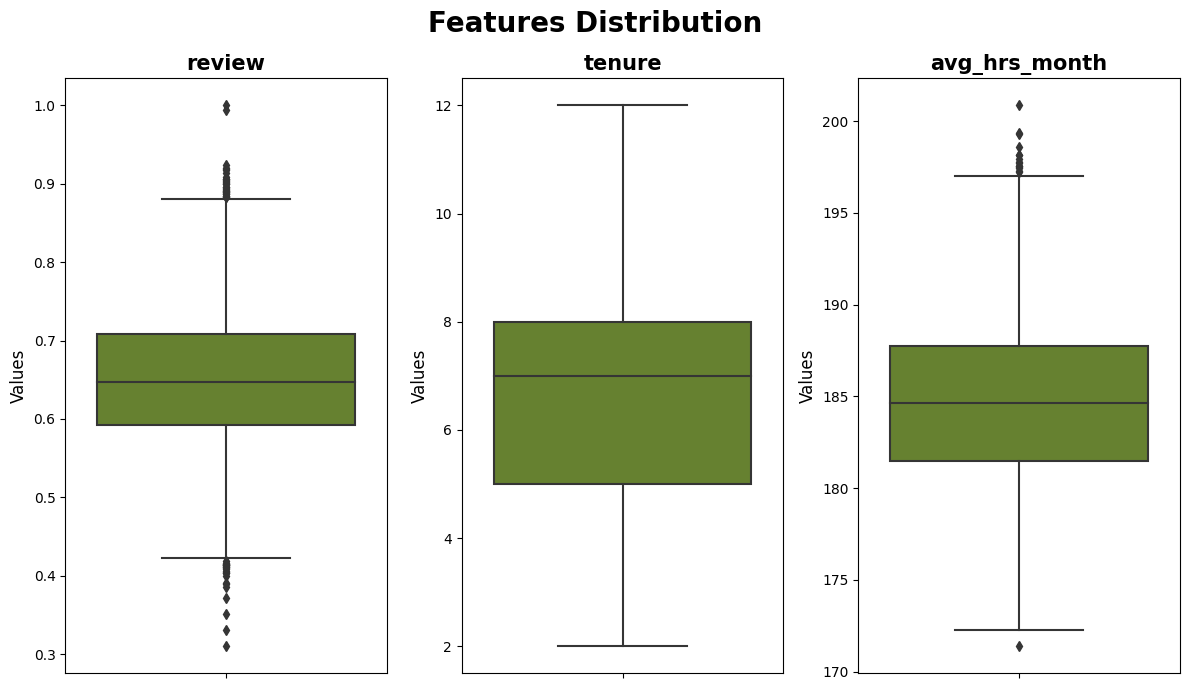

In [12]:
# Checking these features distribution visually

#subset
zscore_features = ['review', 'tenure','avg_hrs_month']

#plot and customize
fig, ax = plt.subplots(1, len(zscore_features), figsize = (12,7))

for idx, feature in enumerate(zscore_features):
    sns.boxplot(data=df,y=feature,color='olivedrab', ax=ax[idx])
    ax[idx].set_ylabel('Values', fontsize = 12)  
    ax[idx].set_xlabel('',fontsize = 12)
    ax[idx].set_title(feature, fontsize = 15, fontweight= 'bold')
    plt.sca(ax[idx]) 
        
plt.suptitle('Features Distribution', fontsize = 20, fontweight = 'bold') 
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.5, wspace=0.4, hspace=0.4)

plt.tight_layout()

> #### Outliers Conclusion

After counting the instances with a Z-score higher or equal to the defined threshold (3.5) per column it's possible to check that the features: `review` (5), `tenure` (1) and `avg_hrs_month` (3) were the only ones with high Z-score observations. 

The ones in `review` were inside the desired range (from 0 to 1), so they weren't considered as errors. As for the ones in `tenure` and `avg_hrs_month` the values were simply distant from its feature's mean. In both of these cases, the high Z-score observations were provident from their highest values but, since they seem realistic (12 years in a company and averaging around 200 hours of work per month) , they weren't considered as errors as well.

### Data Transformation

In [13]:
# Changing the columns names to title text
df.columns = [i.title() for i in df.columns]

# Changing the text feature's values to capitalized text
df[['Department','Salary','Left']] = df[['Department','Salary','Left']].apply(lambda x: x.str.capitalize())

# Changing Left feature to binary 
df['Left'] = df['Left'].apply(lambda x: 0 if x == 'No' else 1)

# Changing Salary feature to numerical 
df['Salary'] = df['Salary'].apply(lambda x: 1 if x == 'Low' else (2 if x == 'Medium' else 3))

# Rounding Review, Satisfaction and Avg_Hrs_Month
df[['Review','Satisfaction','Avg_Hrs_Month']] = df[['Review','Satisfaction','Avg_Hrs_Month']].apply(lambda x: round(x,2))

df.head()

,Department,Promoted,Review,Projects,Salary,Tenure,Satisfaction,Bonus,Avg_Hrs_Month,Left
0,Operations,0,0.58,3,1,5.0,0.63,0,180.87,0
1,Operations,0,0.75,3,2,6.0,0.44,0,182.71,0
2,Support,0,0.72,3,2,6.0,0.45,0,184.42,0
3,Logistics,0,0.68,4,3,8.0,0.44,0,188.71,0
4,Sales,0,0.68,3,3,5.0,0.58,1,179.82,0


### Exploratory Data Analysis 

- Getting a better understanding of data
- Identifying various data patterns
- Getting a better understanding of the problem statement


In [14]:
# Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Promoted,9540.0,0.030294,0.171403,0.00,0.00,0.00,0.00,1.00
Review,9540.0,0.651843,0.085318,0.31,0.59,0.65,0.71,1.00
Projects,9540.0,3.274843,0.579136,2.00,3.00,3.00,4.00,5.00
Salary,9540.0,2.017505,0.553849,1.00,2.00,2.00,2.00,3.00
Tenure,9540.0,6.556184,1.415432,2.00,5.00,7.00,8.00,12.00
Satisfaction,9540.0,0.504617,0.158583,0.00,0.39,0.50,0.62,1.00
Bonus,9540.0,0.212055,0.408785,0.00,0.00,0.00,0.00,1.00
Avg_Hrs_Month,9540.0,184.661551,4.144797,171.37,181.47,184.63,187.73,200.86
Left,9540.0,0.291824,0.454626,0.00,0.00,0.00,1.00,1.00


In [15]:
# Original object features statistics 
raw.describe(include='O')

,department,salary,left
count,9540,9540,9540
unique,10,3,2
top,sales,medium,no
freq,1883,6611,6756


In [16]:
# Checking median and mode from numerical features
tmp = df.select_dtypes(include = ['float64', 'int64']) 

for col in tmp.columns: 
    print(f'{col} median :',tmp[col].median())
    print(f'{col} mode :',tmp[col].mode()[0],'\n')

Promoted median : 0.0
Promoted mode : 0 

Review median : 0.65
Review mode : 0.64 

Projects median : 3.0
Projects mode : 3 

Salary median : 2.0
Salary mode : 2 

Tenure median : 7.0
Tenure mode : 6.0 

Satisfaction median : 0.5
Satisfaction mode : 0.43 

Bonus median : 0.0
Bonus mode : 0 

Avg_Hrs_Month median : 184.63
Avg_Hrs_Month mode : 187.24 

Left median : 0.0
Left mode : 0 



In [17]:
# Setting Style 
plt.style.use('seaborn')

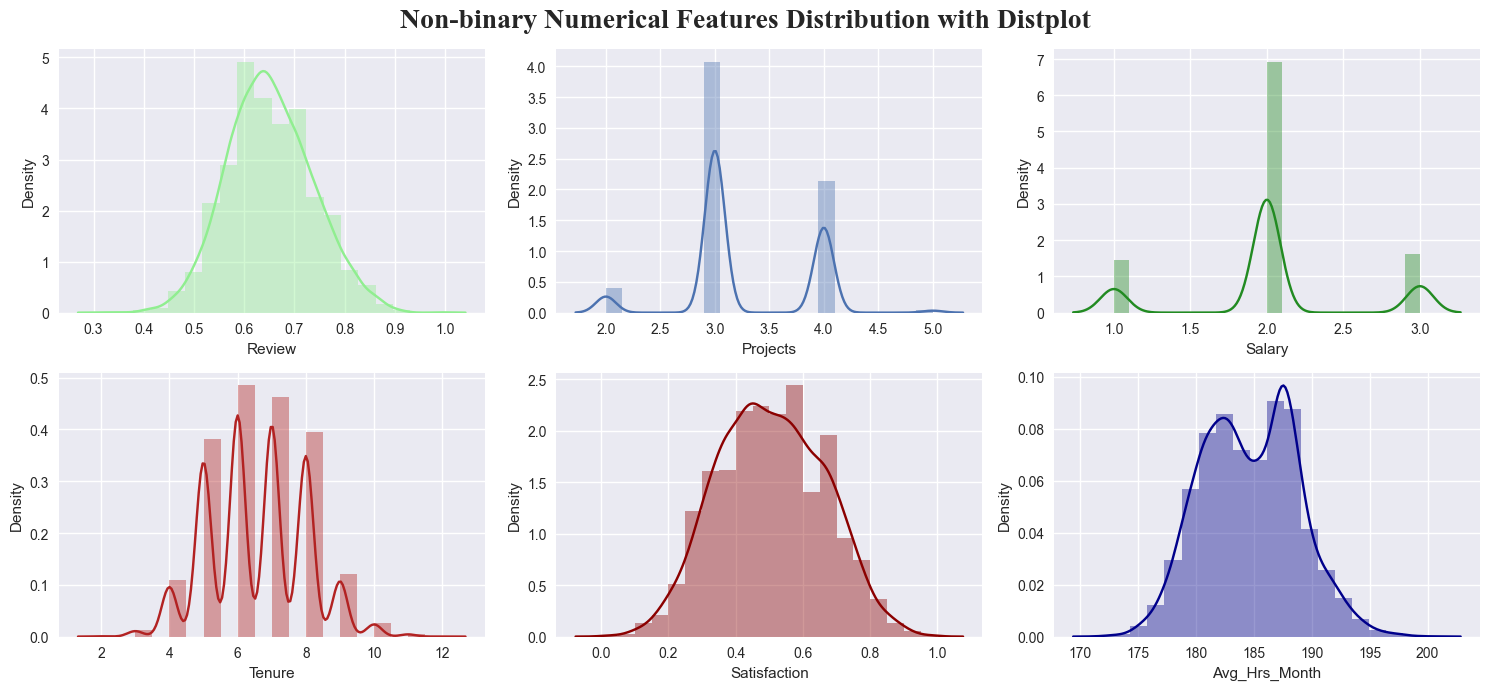

In [18]:
# Numeric features distribution (non-binary)

#subseting numeric features and deleting binary for viz
tmp = df.select_dtypes(include = ['float64', 'int64'])

for col, rows in tmp.items(): 
    if col in tmp:
        if rows.value_counts().shape[0] == 2:
            del tmp[col]
            
#plot

fig, ax = plt.subplots(2, 3, figsize = (15,7)) 

sns.distplot(tmp.iloc[:,0], bins=20, hist_kws={'alpha': 0.4}, color='lightgreen', ax = ax[0,0])
sns.distplot(tmp.iloc[:,1],  bins=20, hist_kws={'alpha': 0.4}, ax = ax[0,1]) 
sns.distplot(tmp.iloc[:,2], bins=20, hist_kws={'alpha': 0.4}, color='forestgreen', ax = ax[0,2])
sns.distplot(tmp.iloc[:,3],  bins=20, hist_kws={'alpha': 0.4}, color='firebrick', ax = ax[1,0]) 
sns.distplot(tmp.iloc[:,4], bins=20, hist_kws={'alpha': 0.4}, color='darkred', ax = ax[1,1])  
sns.distplot(tmp.iloc[:,5], bins=20, hist_kws={'alpha': 0.4}, color='darkblue', ax = ax[1,2])

#customize
plt.rcParams['font.family'] = 'Times New Roman'
plt.suptitle('Non-binary Numerical Features Distribution with Distplot', fontsize = 20, fontweight = 'bold') 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None) 
        

plt.tight_layout()

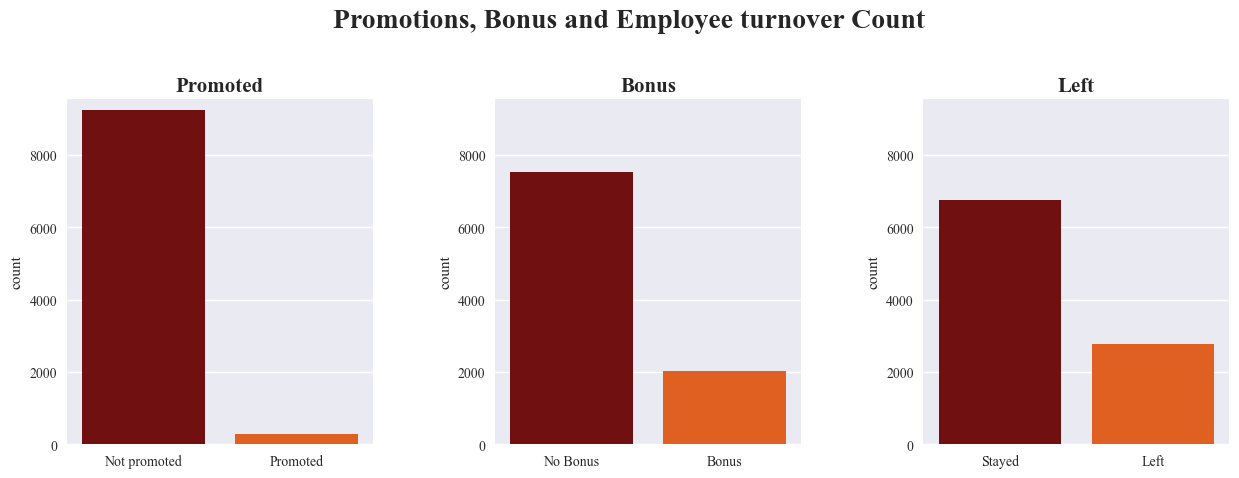


Nº of Promotions : 289 from 9540 employees( 3.03 %) 
Nº of Bonuses : 2023 from 9540 employees( 21.21 %) 
Nº of employee turnovers : 2784 from 9540 employees( 29.18 %)


In [19]:
# Promotions, bonus and employee turnover count
#plot
fig, ax = plt.subplots(1, 3, figsize = (15,5)) 

sns.countplot(data=df,x='Promoted', ax = ax[0], palette= 'gist_heat')
sns.countplot(data=df,x='Bonus', ax = ax[1], palette= 'gist_heat')
sns.countplot(data=df,x='Left', ax = ax[2], palette= 'gist_heat')

#customize
plt.rcParams['font.family'] = 'Times New Roman'
plt.suptitle('Promotions, Bonus and Employee turnover Count',fontsize = 20, fontweight = 'bold')
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.8, wspace=0.4, hspace=None) 


for i in range(3): 
    ax[i].set_ylim(0,len(df))
    ax[i].set_xlabel('')
    plt.sca(ax[i])
    if i == 0: 
        ax[i].set_xticklabels({'Not promoted':0,'Promoted':1})
        ax[i].set_title('Promoted' ,fontsize = 15, fontweight = 'bold')
    elif i == 1: 
        ax[i].set_xticklabels({'No Bonus':0,'Bonus':1})
        ax[i].set_title('Bonus' ,fontsize = 15, fontweight = 'bold')
    else: 
        ax[i].set_xticklabels({'Stayed':0,'Left':1})
        ax[i].set_title('Left' ,fontsize = 15, fontweight = 'bold')
    
plt.show()

#Number of promotions and bonuses
print('\nNº of Promotions :',len(df.loc[df['Promoted'].isin([1])]),'from',len(df),
      'employees(',round(len(df.loc[(df['Promoted'].isin([1]))])* 100 / len(df),2),'%)', 
      '\nNº of Bonuses :',len(df.loc[df['Bonus'].isin([1])]),'from',len(df),
      'employees(',round(len(df.loc[(df['Bonus'].isin([1]))])* 100 / len(df),2),'%)', 
      '\nNº of employee turnovers :',len(df.loc[df['Left'].isin([1])]),'from',len(df),
      'employees(',round(len(df.loc[(df['Left'].isin([1]))])* 100 / len(df),2),'%)')

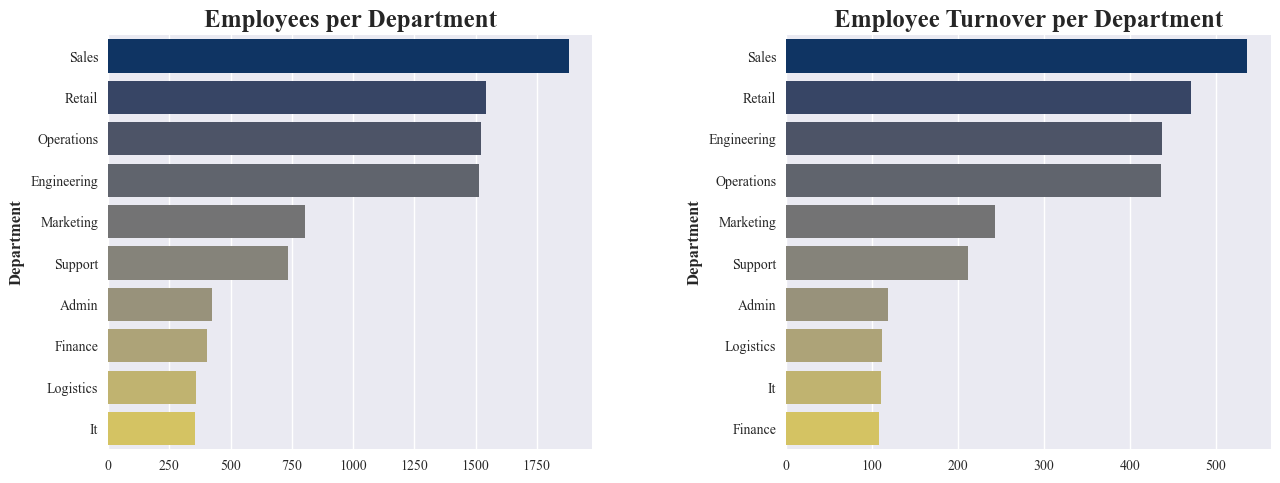

In the Operations Department:

Nº of Turnovers: 436 from 1522 employees (28.65%)

In the Support Department:

Nº of Turnovers: 212 from 735 employees (28.84%)

In the Logistics Department:

Nº of Turnovers: 111 from 360 employees (30.83%)

In the Sales Department:

Nº of Turnovers: 537 from 1883 employees (28.52%)

In the It Department:

Nº of Turnovers: 110 from 356 employees (30.9%)

In the Admin Department:

Nº of Turnovers: 119 from 423 employees (28.13%)

In the Engineering Department:

Nº of Turnovers: 437 from 1516 employees (28.83%)

In the Marketing Department:

Nº of Turnovers: 243 from 802 employees (30.3%)

In the Finance Department:

Nº of Turnovers: 108 from 402 employees (26.87%)

In the Retail Department:

Nº of Turnovers: 471 from 1541 employees (30.56%)



In [20]:
# Employee turnover per department
#subset 
tmp = df.groupby('Department', as_index=False)[['Left']].count().sort_values('Left', ascending=False) 
tmp1 = df.groupby('Department', as_index=False)[['Left']].sum().sort_values('Left', ascending=False) 

#plot
fig, ax = plt.subplots(1,2,figsize = (15, 6))

sns.barplot(data=tmp,y='Department', x='Left', palette= 'cividis', ax=ax[0])
sns.barplot(data=tmp1,y='Department', x='Left', palette= 'cividis', ax=ax[1])

#customize 
plt.rcParams['font.family'] = 'Times New Roman'
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.8, wspace=0.4, hspace=None) 

for i in range(2): 
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Department',fontsize = 12, fontweight = 'bold')
    
ax[0].set_title('Employees per Department',fontsize = 18, fontweight = 'bold') 
ax[1].set_title('Employee Turnover per Department',fontsize = 18, fontweight = 'bold')

plt.show()

#Number of turnovers and employees
for i in df['Department'].unique(): 
    turnovers = len(df.loc[(df['Department']==i) & df['Left']==1])
    employees = len(df.loc[df['Department']==i])
    print(f'In the {Fore.GREEN}{i}{Style.RESET_ALL}',
         f'Department:\n\nNº of Turnovers: {Fore.RED}{turnovers}{Style.RESET_ALL}',
         'from', employees, f'employees ({round(turnovers/employees*100,2)}%)\n')

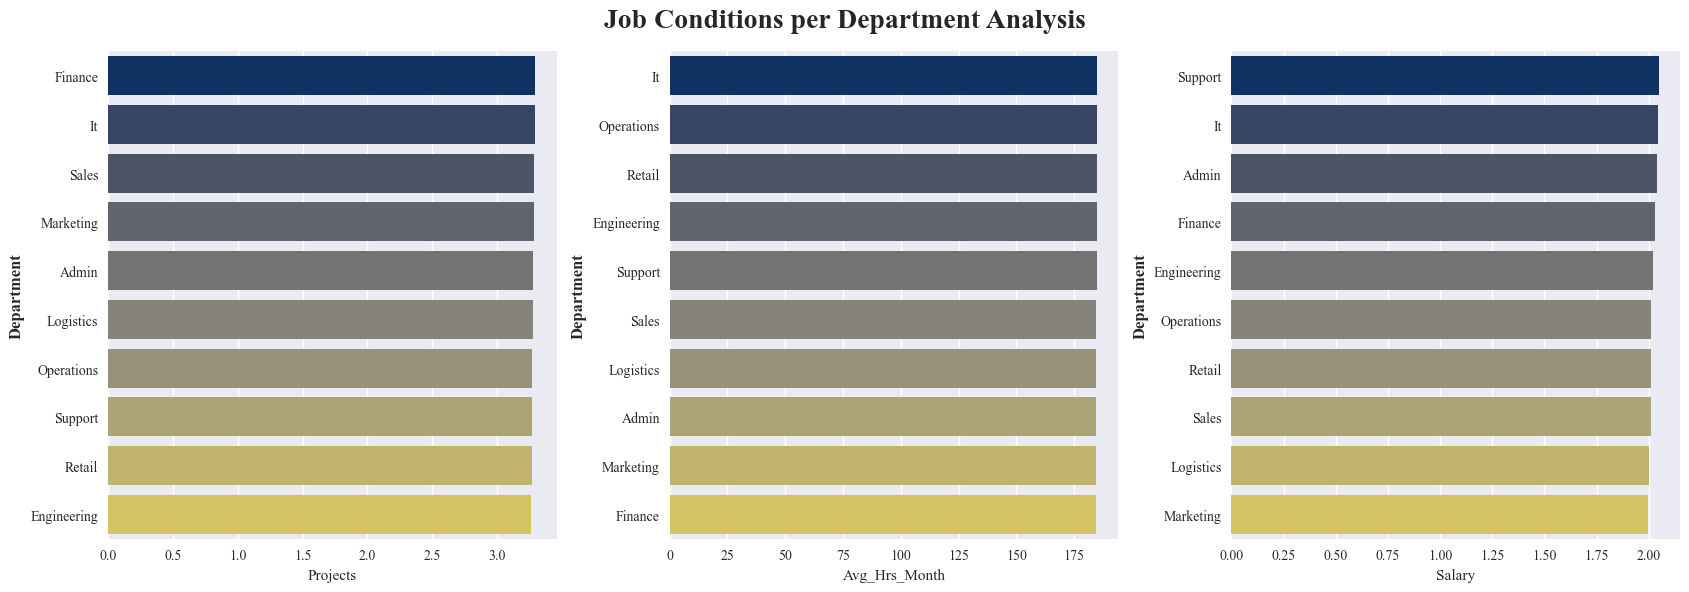

In [21]:
# Employee job conditions analysis per department
#subset 
tmp = df.groupby('Department', as_index=False)[['Projects']].mean().sort_values('Projects', ascending=False) 
tmp1 = df.groupby('Department', as_index=False)[['Avg_Hrs_Month']].mean().sort_values('Avg_Hrs_Month', ascending=False)
tmp2 = df.groupby('Department', as_index=False)[['Salary']].mean().sort_values('Salary', ascending=False)

#plot
fig, ax = plt.subplots(1,3, figsize=(17,6))

sns.barplot(data=tmp,y='Department', x='Projects', palette= 'cividis', ax=ax[0])
sns.barplot(data=tmp1,y='Department', x='Avg_Hrs_Month', palette= 'cividis', ax=ax[1])
sns.barplot(data=tmp2,y='Department', x='Salary', palette= 'cividis', ax=ax[2])

#customize 
plt.rcParams['font.family'] = 'Times New Roman'
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.8, wspace=0.4, hspace=None) 

for i in range(3):
        ax[i].set_ylabel('Department',fontsize = 12, fontweight = 'bold')
        plt.sca(ax[i])

plt.suptitle('Job Conditions per Department Analysis', fontsize = 20, fontweight = 'bold')

plt.tight_layout()

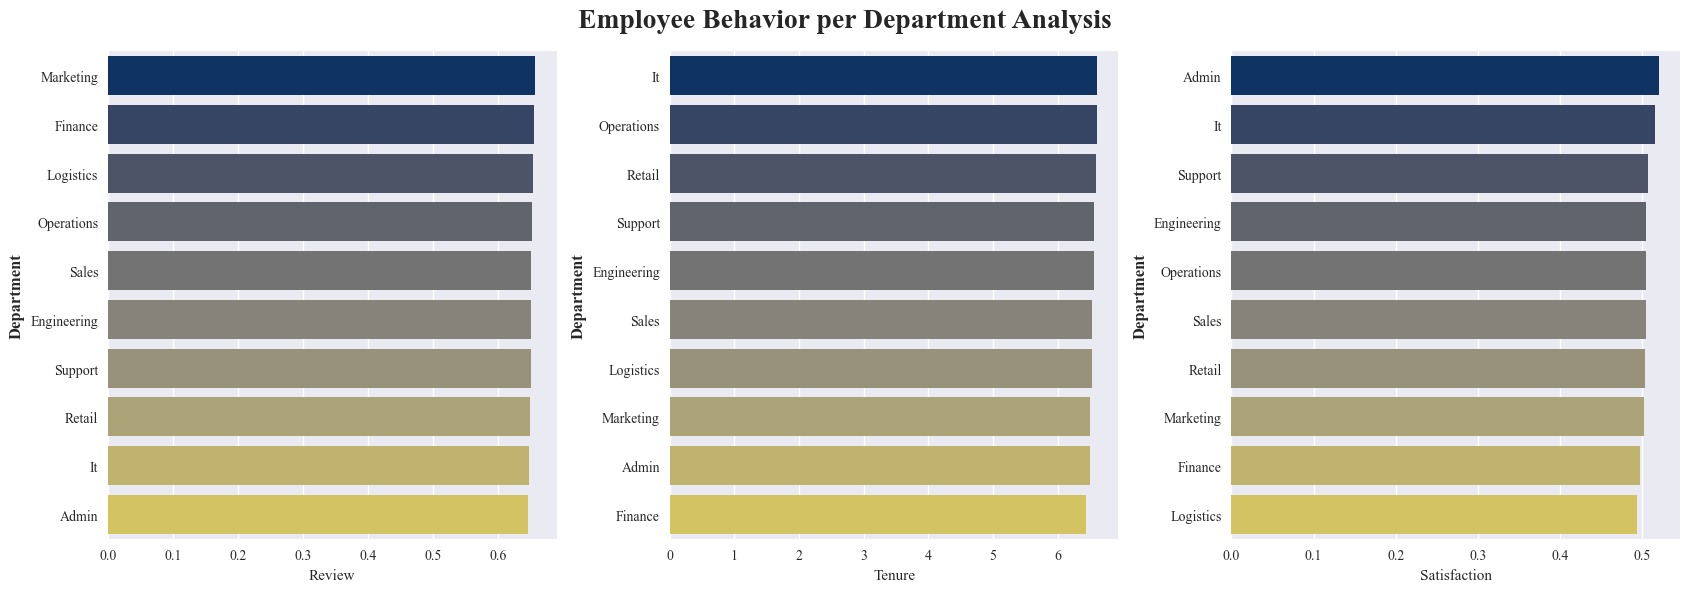

In [22]:
# Employee behavior analysis per department
#subset 
tmp = df.groupby('Department', as_index=False)[['Review']].mean().sort_values('Review', ascending=False) 
tmp1 = df.groupby('Department', as_index=False)[['Tenure']].mean().sort_values('Tenure', ascending=False) 
tmp2 = df.groupby('Department', as_index=False)[['Satisfaction']].mean().sort_values('Satisfaction', ascending=False)

#plot
fig, ax = plt.subplots(1,3, figsize=(17,6))

sns.barplot(data=tmp,y='Department', x='Review', palette= 'cividis', ax=ax[0])
sns.barplot(data=tmp1,y='Department', x='Tenure', palette= 'cividis', ax=ax[1])
sns.barplot(data=tmp2,y='Department', x='Satisfaction', palette= 'cividis', ax=ax[2])

#customize 
plt.rcParams['font.family'] = 'Times New Roman'
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.8, wspace=0.4, hspace=None) 

for i in range(3):
        ax[i].set_ylabel('Department',fontsize = 12, fontweight = 'bold')
        plt.sca(ax[i])

plt.suptitle('Employee Behavior per Department Analysis', fontsize = 20, fontweight = 'bold')

plt.tight_layout()

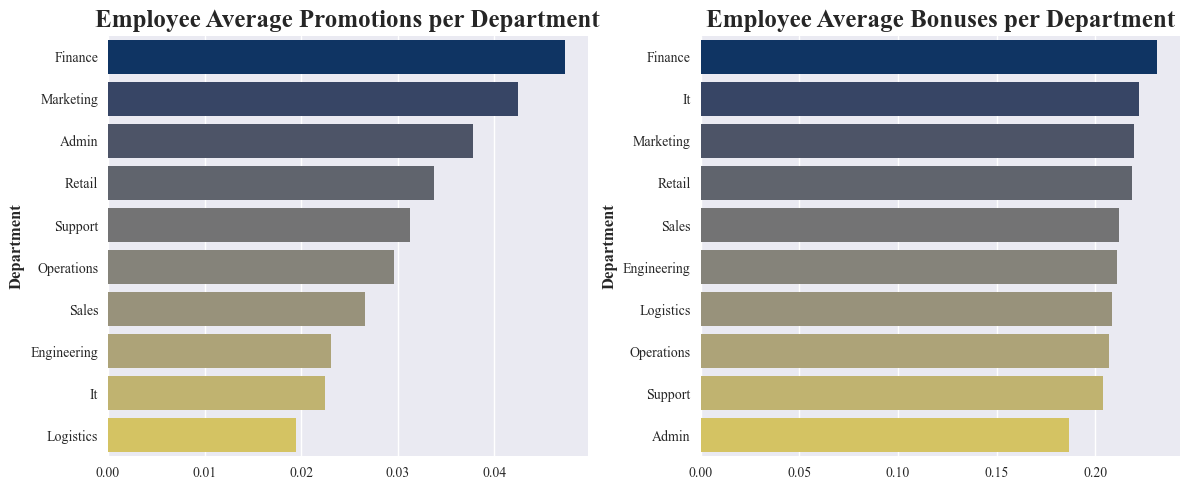

In [23]:
# Employee average promotions and bonuses per department
#subset 
tmp = df.groupby('Department', as_index=False)[['Promoted']].mean().sort_values('Promoted', ascending=False) 
tmp1 = df.groupby('Department', as_index=False)[['Bonus']].mean().sort_values('Bonus', ascending=False) 
#plot
fig, ax = plt.subplots(1,2,figsize = (12, 5))

sns.barplot(data=tmp,y='Department', x='Promoted', palette= 'cividis', ax=ax[0])
sns.barplot(data=tmp1,y='Department', x='Bonus', palette= 'cividis', ax=ax[1])

#customize 
plt.rcParams['font.family'] = 'Times New Roman'
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None) 

for i in range(2): 
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Department',fontsize = 12, fontweight = 'bold')
    
ax[0].set_title('Employee Average Promotions per Department',fontsize = 18, fontweight = 'bold') 
ax[1].set_title('Employee Average Bonuses per Department',fontsize = 18, fontweight = 'bold')

plt.tight_layout()

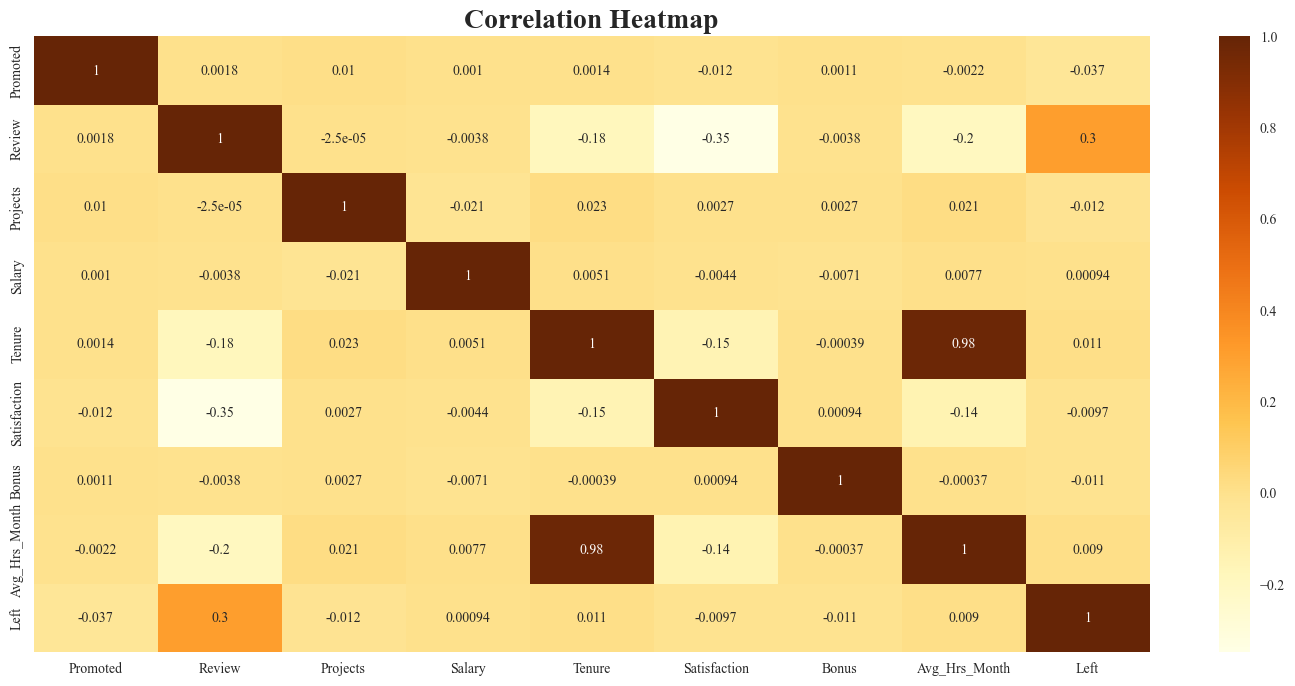

The features Avg_Hrs_Month and Tenure presented 0.98 of correlation value, meaning there´s a positive correlation that confers a very strong relationship in which variables increase or decrease simultaneously to each other.

The features Review and Satisfaction presented -0.35 of correlation value, meaning there´s a negative correlation that confers a moderate relationship in which variables increase or decrease inversely to each other.

The features Review and Left presented 0.3 of correlation value, meaning there´s a positive correlation that confers a moderate relationship in which variables increase or decrease simultaneously to each other.

The features Review and Avg_Hrs_Month presented -0.2 of correlation value, meaning there´s a negative correlation that confers a weak relationship in which variables increase or decrease inversely to each other.

The features Tenure and Review presented -0.18 of correlation value, meaning there´s a negative correlation that confers a weak relat

In [24]:
# Correlations analysis
#plot
cmap = sns.color_palette('YlOrBr', as_cmap=True)

plt.figure(figsize = (18, 8))
sns.heatmap(data = df.corr(), annot = True, cmap = cmap)

#customize
plt.title('Correlation Heatmap',fontsize = 20, fontweight = 'bold')

plt.show() 

#considerable correlation value (higher than 0.10 and lower than -0.10)
x = round(df['Avg_Hrs_Month'].corr(df['Tenure']),2)
y = round(df['Review'].corr(df['Satisfaction']),2)
z = round(df['Review'].corr(df['Left']),2)
m = round(df['Review'].corr(df['Avg_Hrs_Month']),2)
n = round(df['Tenure'].corr(df['Review']),2) 
b = round(df['Satisfaction'].corr(df['Avg_Hrs_Month']),2) 


#correlation dictionary from relevant features
dict = {'Avg_Hrs_Month and Tenure': x, 
    'Review and Satisfaction': y, 
    'Review and Left': z, 
    'Review and Avg_Hrs_Month': m, 
    'Tenure and Review': n,
    'Satisfaction and Avg_Hrs_Month': b}

#correlation loop
for cols, corr in dict.items():  
    
    if corr >= 0 and corr <= 0.05 or corr <= 0 and corr >= -0.05: 
        Relationship = 'no relationship' 
    elif corr >= 0.05 and corr <= 0.25 or corr <= -0.05 and corr >= -0.25: 
        Relationship = 'weak relationship' 
    elif corr > 0.25 and corr <= 0.50 or corr < -0.25 and corr >= -0.50 : 
        Relationship = 'moderate relationship' 
    elif corr > 0.50 and corr <= 0.75 or corr < -0.50 and corr >= -0.75 : 
        Relationship = 'strong relationship' 
    else: 
        Relationship = 'very strong relationship' 
    if corr > 0.05 : 
        Correlation = 'positive correlation' 
        Behavior = 'simultaneously to each other'
    elif corr < 0: 
        Correlation = 'negative correlation' 
        Behavior = 'inversely to each other'
    else: 
        Correlation = 'no correlation'
        Behavior = 'indenpendently to each other' 

    print(f'The features {Fore.GREEN}{cols}{Style.RESET_ALL} presented {Fore.RED}{corr}{Style.RESET_ALL} of correlation value, meaning there´s a {Fore.YELLOW}{Correlation}{Style.RESET_ALL} that confers a {Fore.CYAN}{Relationship}{Style.RESET_ALL} in which variables increase or decrease {Fore.LIGHTMAGENTA_EX}{Behavior}{Style.RESET_ALL}.\n') 

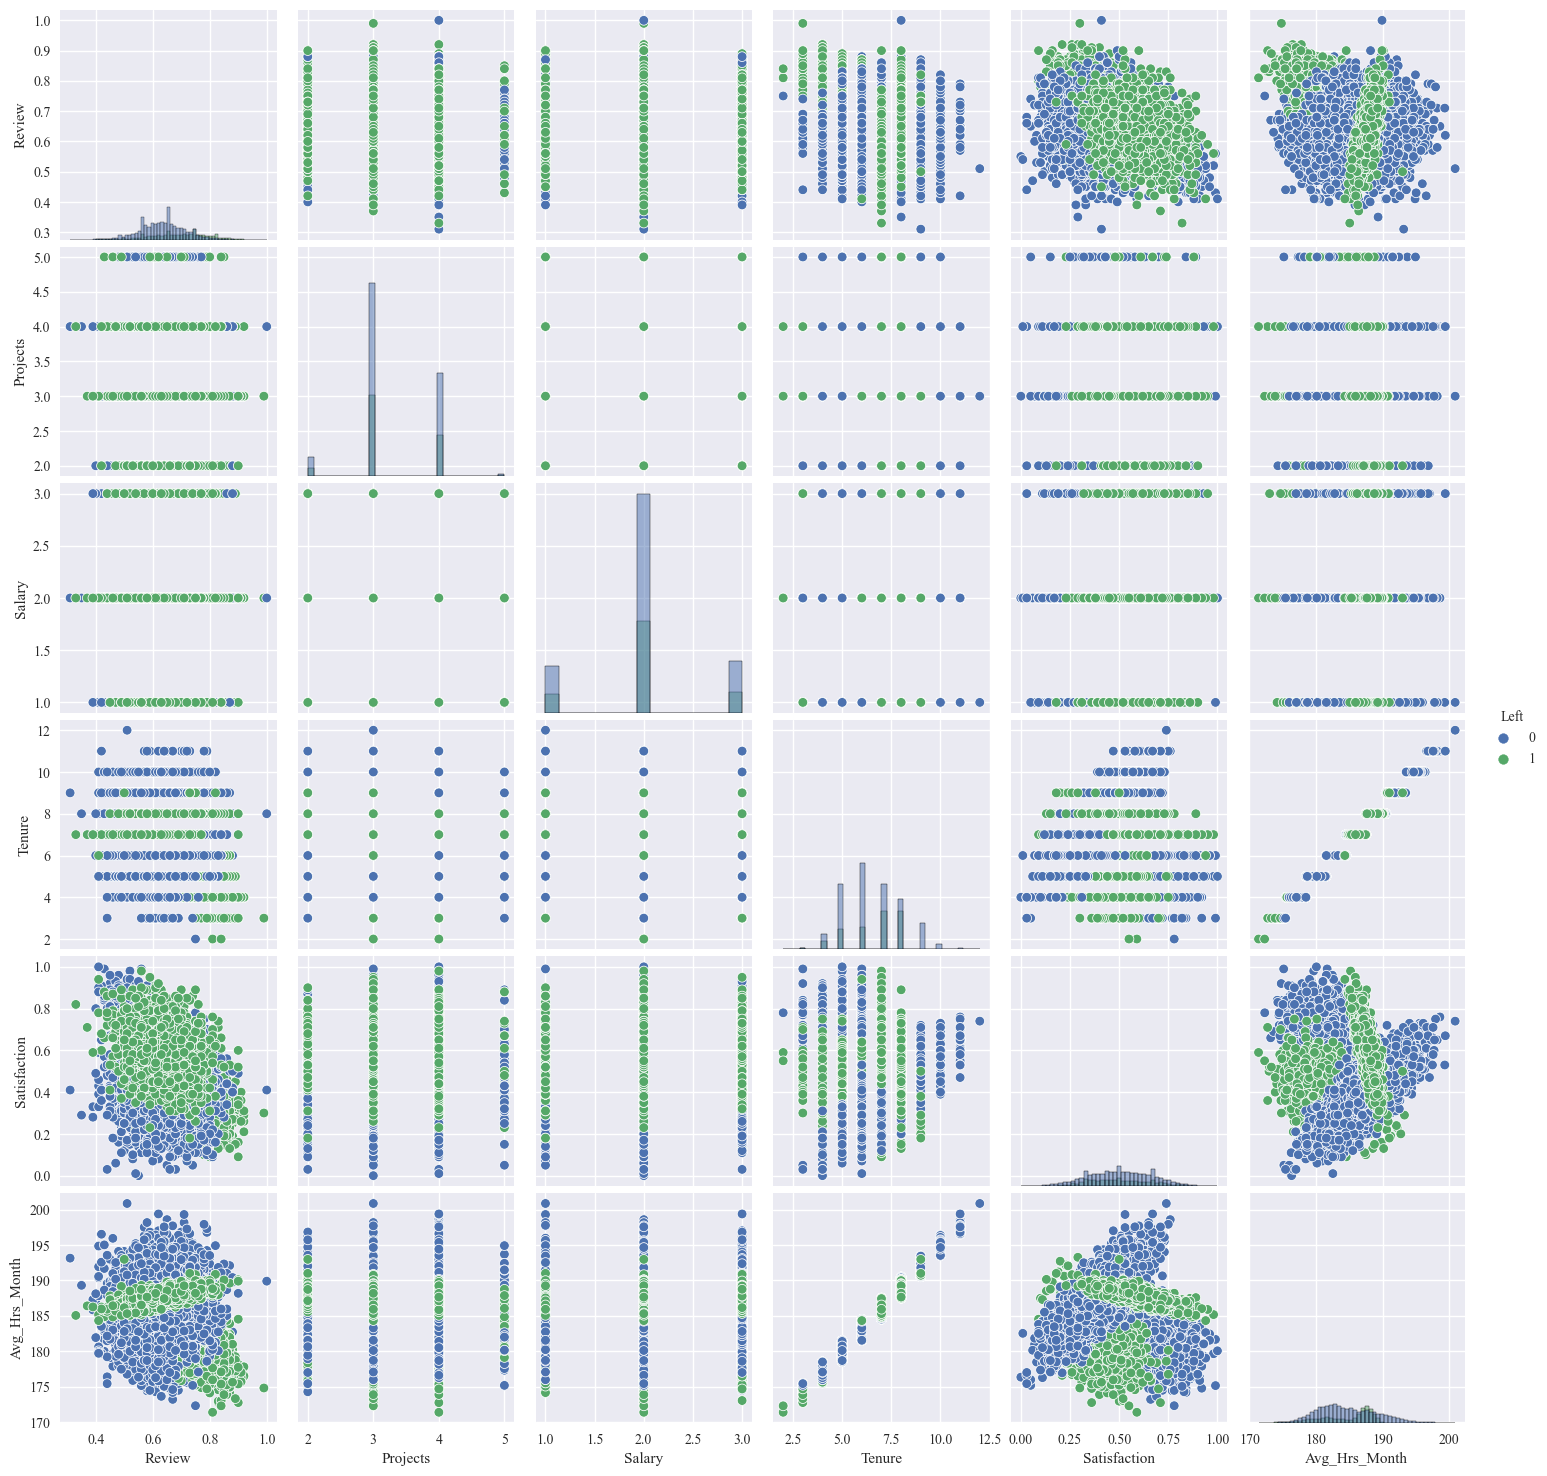

In [25]:
# Checking correlations visually

#deleting binary features for viz
tmp = df.copy()
for col, rows in tmp.items(): 
    if col in tmp.select_dtypes(include = ['float64', 'int64']):
        if rows.value_counts().shape[0] == 2:
            del tmp[col]
            
#recovering left to use as hue            
tmp['Left']=df['Left']

#plot
sns.pairplot(tmp, diag_kind = 'hist', hue='Left') 
            
plt.show()

> #### EDA Final Insights

The Exploratory Data Analysis showed that not many employees were promoted (only 3%) and neither received a bonus (21%) in the past 24 months. There is an extremely high employee turnover, reaching almost 30% of the total workforce.

The average employee `Review` is 0.65 and `Tenure` 6.55, meaning employees tend to stay for a while in the company and to perform quite well. The average number of `Project` involved is 3 and of hours of work per month (`Avg_Hours_Month`) is 184, which is quite normal. The average `Salary` is medium (2.01) but the `Satisfaction` levels seemed quite low as its average is 0.50.

The `Departments` with more employees are the Sales, Retail, Engineering and Operations with more than 1500 staff members each. The employee turnover per department seemed proportional in comparison with the number of staff per each, with an employee turnover rate rounding the 30% in all departments. On a special note, the It and Logistics are the smallest departments among all sections, but they’re also the ones with higher turnover rate, with almost 31% each, meaning almost a third part of the workforce left in these two. 

In terms of labor conditions all departments seem to have the same conditions which means that the average hours per work, the salary, the number of projects involved were similar, affecting the satisfaction and review (productivity) rates which were also alike. The section were its employees have better odds of being promoted or receive a bonus is the Finance department but the chances are still very low. Curiously, this department is also the one with the lowest turnover rate (26.87%) furthermore, its `Satisfaction` average is the second worst. Is there a correlation between the variables `Promoted` or `Bonus` with staying in the company? Does lack of `Satisfaction` causes people to leave? 

To answer these questions, a correlation analysis was performed and the takeaway is clear, there's lack of a meritocracy system. It would be expected a positive correlation between the variables `Left` or `Satisfaction` with perhaps `Promoted` or `Bonus`, which is not the case. Two of the strongest correlations on the data are related with the variable `Review`, with a correlation coefficient of -0.35 with `Satisfaction` and of 0.30 with `Left`. Are the best employees less satisfied and leaving? And if so, why? Also, there's an almost perfect correlation between the variables `Tenure` and `Avg_Hours_Month`, meaning the longer the employee stays in the company, the more hours he works. Is this appealing to the staff members?

### Clustering Strategy 

It'll be performed a clustering analysis, to find which groups are departing, and why they're doing so.

For the the employee segmentation It'll be used the succeeding features:

*    `Review` - The composite score the employee received in their last evaluation.
*    `Satisfaction`- A measure of employee satisfaction from surveys.
*    `Avg_Hrs_Month` - The average hours the employee worked in a month.

These variables were chosen because they made more sense for the clustering in terms of separating employee behavior, since they sum up the employees most important characteristics. To avoid problems that may arise by using highly correlated features as inputs for clustering, it's a good procedure to remove one of two variables in case their correlation is higher than 0.70 or lower than -0.70. Since these three don't have high correlation values, none of them will be removed or replaced.

The feature `Avg_Hrs_Month` is highly correlated with `Tenure`, so it does not only describe the labor period in hours, but also gives a glimpse of how many years the employee has been at the company. `Review` reveals the staff members' performance score and `Satisfaction` is the employee's happiness at work metric. The rest of the variables will be contemplated after the cluster is done. With theses variables, it's possible to group the employees by value to the company.

To define the optimal n_clusters (k), it'll be used the Elbow plot along with the Silhouette Plot to support decision making regarding various perspectives. After k is defined, the clustering will take action followed by a segment behavior analysis through visualizations.

Finally, employee groups will be profiled and there will be a conclusion with the clustering takeaways.


### Selecting Cluster Variables

In [26]:
# Creating a copy to add clustered results
df_cluster = df.copy()

In [27]:
# Creating dataframe with relevant features for the employee segmentation 
turnover_features = ['Review', 'Satisfaction', 'Avg_Hrs_Month']
turnover = df[turnover_features]
turnover.head()

,Review,Satisfaction,Avg_Hrs_Month
0,0.58,0.63,180.87
1,0.75,0.44,182.71
2,0.72,0.45,184.42
3,0.68,0.44,188.71
4,0.68,0.58,179.82


In [28]:
# Checking correlations
turnover.corr()

,Review,Satisfaction,Avg_Hrs_Month
Review,1.000000,-0.349711,-0.196318
Satisfaction,-0.349711,1.000000,-0.143262
Avg_Hrs_Month,-0.196318,-0.143262,1.000000


In [29]:
# Normalizing data
scaler = MinMaxScaler().fit(turnover)
scaled_turnover = scaler.transform(turnover)
scaled_turnover

array([[0.39130435, 0.63      , 0.3221431 ],
       [0.63768116, 0.44      , 0.38453713],
       [0.5942029 , 0.45      , 0.44252289],
       ...,
       [0.36231884, 0.71      , 0.51407257],
       [0.39130435, 0.61      , 0.55171244],
       [0.46376812, 0.71      , 0.49338759]])

###  Determing n_clusters (k)

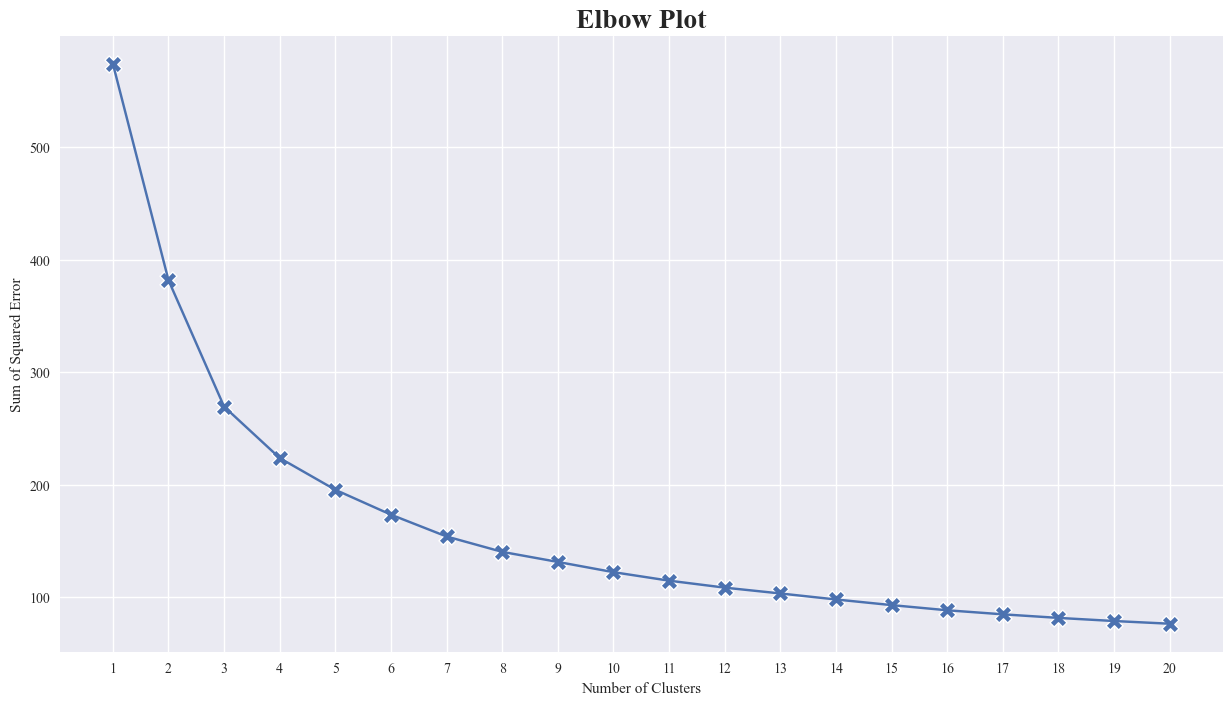

Total error: 76.57

Best candidates for number of clusters: 2, 3, 4 and 5;


In [30]:
# Choosing optimal number of clusters through sum of squared errors plot
sse = []
n_clusters = 20

for k in range(1, n_clusters + 1):
    km = KMeans(n_clusters=k, random_state=0).fit(scaled_turnover)
    sse.append(km.inertia_) 
    
#creating a dataframe for the sum of squared error results
df_sse = pd.DataFrame({'Number of Clusters': range(1, n_clusters + 1), 'Sum of Squared Error': sse})

#plotting sum of squared error results
plt.figure(figsize = (15, 8))
sns.lineplot(df_sse, x = 'Number of Clusters', y = 'Sum of Squared Error')
sns.scatterplot(df_sse, x = 'Number of Clusters', y = 'Sum of Squared Error', marker = 'X', s = 150)

#customizing
plt.xticks(range(1, n_clusters +1, 1))
plt.title('Elbow Plot', fontweight = 'bold', fontsize=20)

plt.show() 

print(f'Total error: {round(km.inertia_,2)}\n\nBest candidates for number of clusters: 2, 3, 4 and 5;')

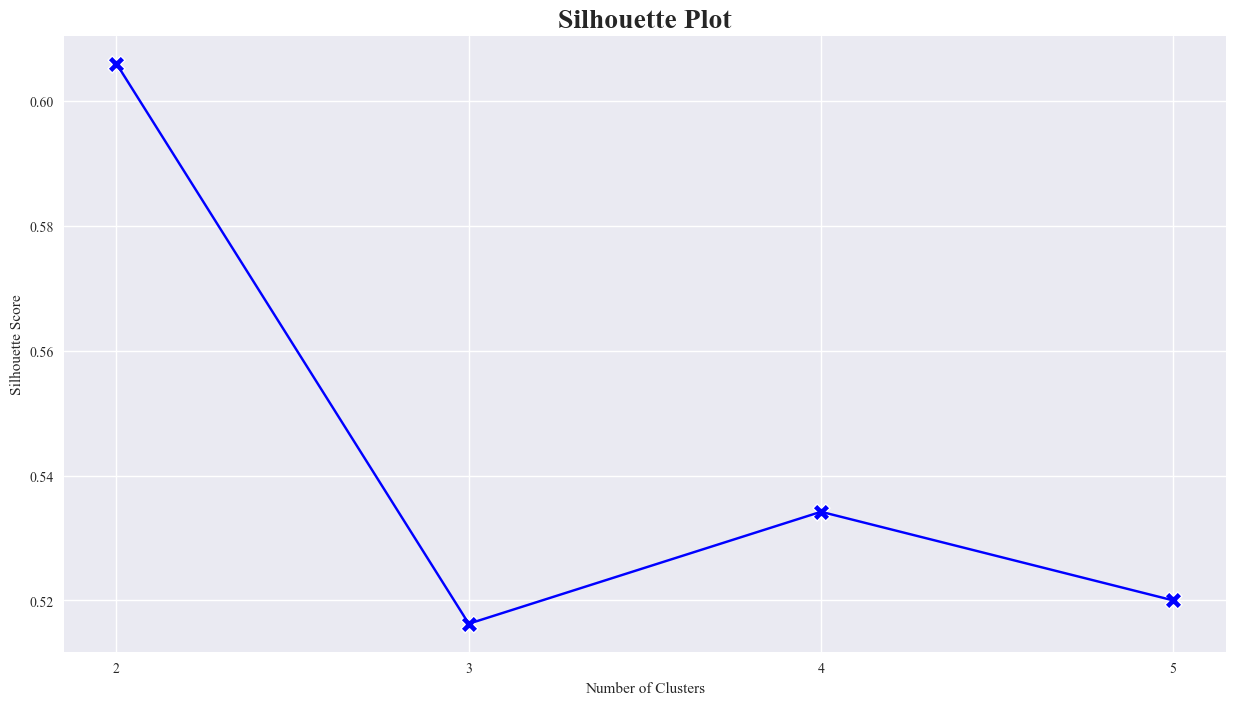

For n_clusters = 2 The average silhouette score is : 0.61
For n_clusters = 3 The average silhouette score is : 0.52
For n_clusters = 4 The average silhouette score is : 0.53
For n_clusters = 5 The average silhouette score is : 0.52


In [31]:
# Benchmarking clusters by measuring the degree of separation between candidates for k through silhouette score 
candidates = [2,3,4,5] 
sc = [] 

for n_clusters in candidates:
    km = KMeans(n_clusters=n_clusters, random_state=0)
    km_labels = km.fit_predict(turnover)
    score = silhouette_score(turnover, km_labels)
    sc.append(score) 
    
#creating a dataframe for the sum of silhouette score
df_sc = pd.DataFrame({'Number of Clusters': range(2, 6), 'Silhouette Score': sc})

#plotting sum of squared error results
plt.figure(figsize = (15, 8))
sns.lineplot(df_sc, x = 'Number of Clusters', y = 'Silhouette Score', color='blue')
sns.scatterplot(df_sc, x = 'Number of Clusters', y = 'Silhouette Score', marker = 'X', s = 150,color='blue')

#customizing
plt.xticks([2,3,4,5])
plt.title('Silhouette Plot', fontweight='bold', fontsize=20)

plt.show()  

# printing silhouette scores
for n_clusters in candidates:  
    km = KMeans(n_clusters=n_clusters, random_state=0)
    km_labels = km.fit_predict(turnover)
    score = silhouette_score(turnover, km_labels)
    print('For n_clusters =', n_clusters,'The average silhouette score is :',round(score,2))

> #### Silhouette Score Takeaways 

The silhouette score gives a perspective into the separation and density of the formed clusters, it has a range of [-1, 1] and when near +1, indicates that the sample is dense and far away from the neighboring clusters. Taking this into consideration and after analyzing the lineplot and the silhouette scores, it's possible to observe that 2 and 4 seem to be the optimal number of clusters, it'll now be confirmed visually.

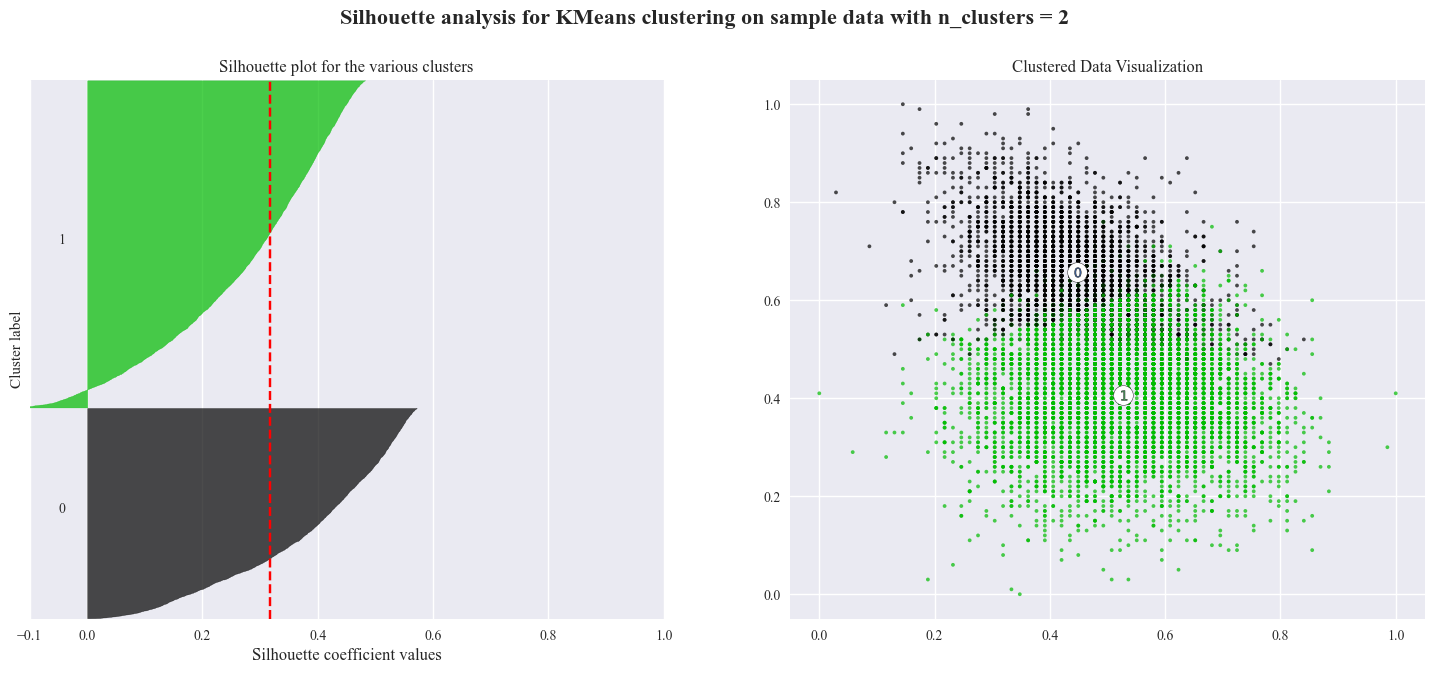

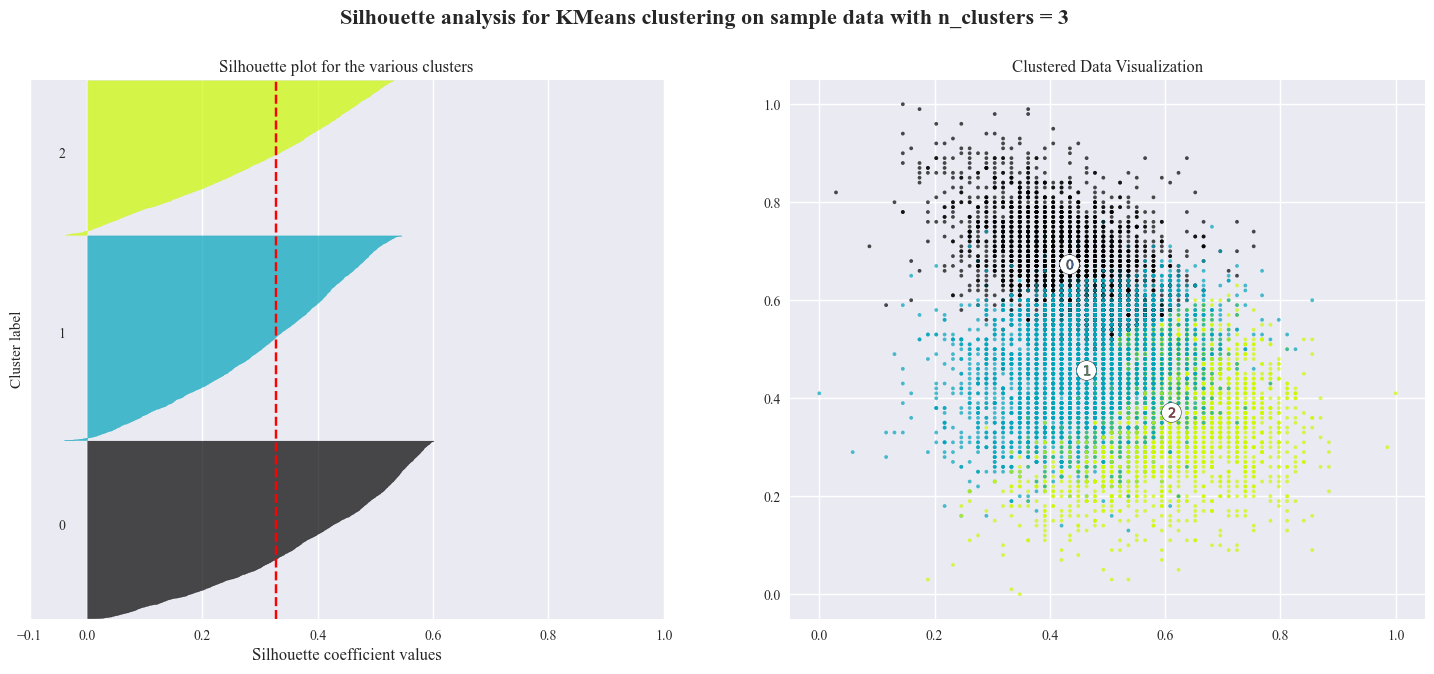

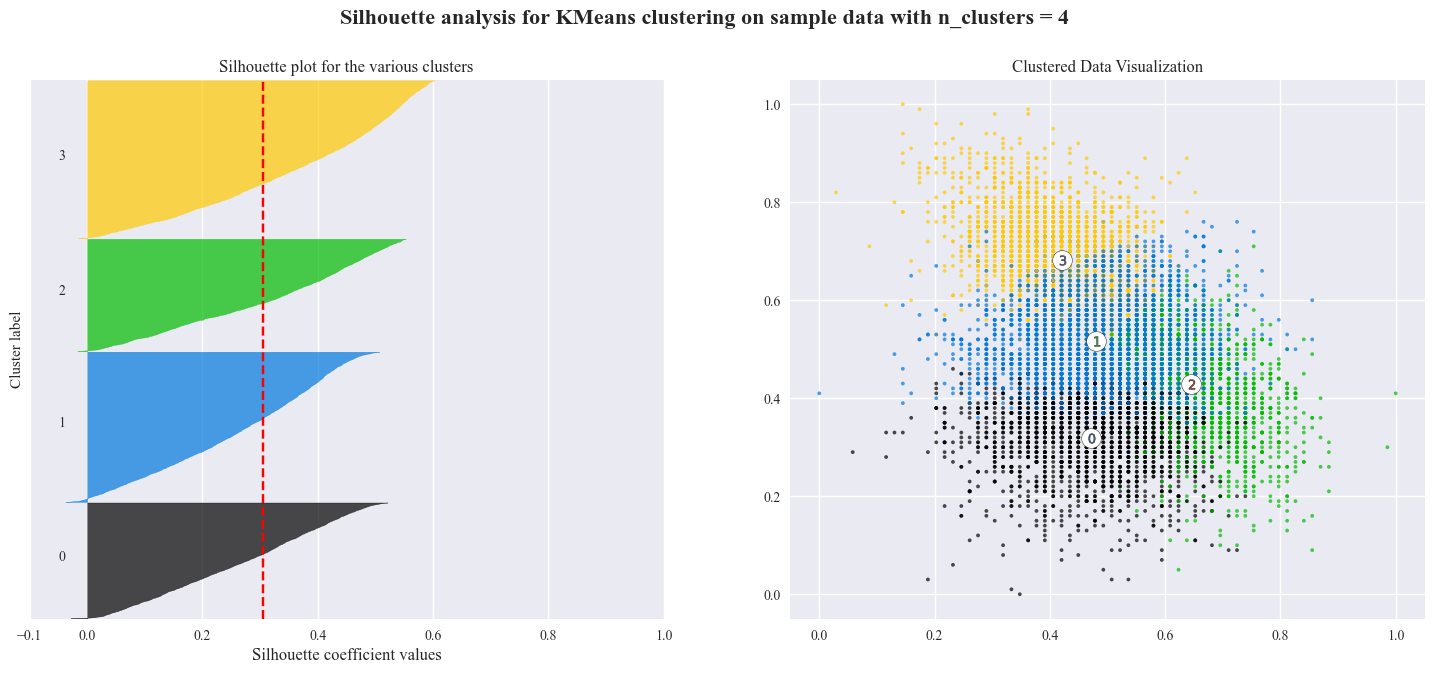

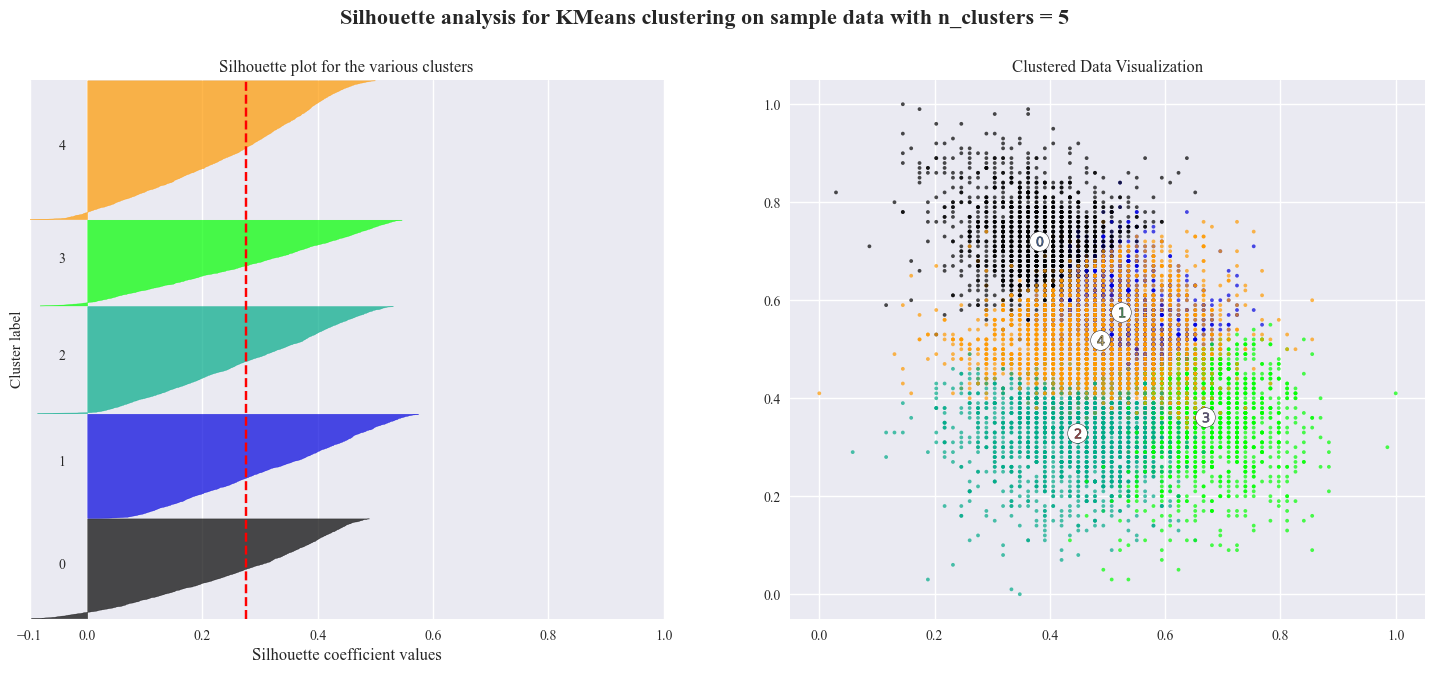

In [32]:
# Checking candidates cluster separation and density visually

for n_clusters in candidates:
    # Creating a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # The 1st subplot is the silhouette plot 
    # The silhouette coefficient can range from [-1, 1]
    ax1.set_xlim([-0.1, 1])
    # (n_clusters+1)*10 is used for the insertion of a blank space between silhouetteplots to demarcate them
    ax1.set_ylim([0, len(scaled_turnover) + (n_clusters + 1) * 10])
    
    # Initializing the km with n_clusters value and a random generator seed of 10 for reproducibility
    km = KMeans(n_clusters=n_clusters, random_state=0)
    km_labels = km.fit_predict(scaled_turnover)
    silhouette_avg = silhouette_score(scaled_turnover, km_labels)
    
    # Computing the silhouette scores for each sample
    sample_values = silhouette_samples(scaled_turnover, km_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregating the silhouette scores for samples belonging to cluster i and sorting them
        ith_cluster_values = sample_values[km_labels == i]
        ith_cluster_values.sort()
        size_cluster_i = ith_cluster_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        # Labeling the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Computing the new y_lower for next plot (10 for the 0 samples)
        y_lower = y_upper + 10
    
    ax1.set_title('Silhouette plot for the various clusters', fontsize=12)
    ax1.set_xlabel('Silhouette coefficient values', fontsize=12)
    ax1.set_ylabel('Cluster label')

    # Setting the vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
    
    # Clearing the y axis ticks and setting the x axis ticks on a range from [-1,1] with 0.2 sep
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(km_labels.astype(float) / n_clusters)
    ax2.scatter(
        scaled_turnover[:, 0], scaled_turnover[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
    )
    # Labeling the clusters
    centers = km.cluster_centers_
    # Drawing white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker='o',
        c='white',
        alpha=1,
        s=200,
        edgecolor='k',
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title('Clustered Data Visualization')
    ax2.set_xlabel('')
    ax2.set_ylabel('')

    plt.suptitle(
        'Silhouette analysis for KMeans clustering on sample data with n_clusters = %d'
        % n_clusters,
        fontsize=16,
        fontweight='bold',
    ) 
    plt.plot() 

> #### Employee Segmentation Optimal n_clusters (k) Conclusion

After analyzing the silhouette plot it turns out that all candidates have a similar average silhouette score (k=2 has a slightly higher score) and that all their clusters are above silhouette score average (X axis red vertical line). The fluctuation in its size is quite similar for all n_cluster candidates however, knowing that from the thickness of the silhouette plot clusters size can be visualized, the values of k as 2 and 4 seem suboptimal as they present wide variance of segments size.

The value of k=3 seems to be the optimal one, its fluctuation in size is consistent, its silhouette thickness is the most uniform among the candidates and all of its clusters are above silhouette score average. Also, from a redundancy perspective, the groups formed when k=3 make more sense for analysis purposes, because when k=5, there are segments that present very similar characteristics.

So it'll be assumed that 3 is the optimal number of clusters.

### Clustering

In [33]:
# Adding the cluster labels as a new feature called turnover_segmentation in my clustered dataset
k = 3
km = KMeans(n_clusters=k, random_state=0).fit(scaled_turnover) 
labels = km.labels_
df_cluster['turnover_segmentation'] = labels

# Checking turnover segmentation features according to centroids 
centroids = df_cluster.groupby('turnover_segmentation')[turnover_features].mean().round(2)
centroids

,Review,Satisfaction,Avg_Hrs_Month
turnover_segmentation,,,
0,0.61,0.67,182.29
1,0.63,0.46,188.61
2,0.73,0.37,182.16


In [34]:
# Naming each one of the clusters according to what they represent 
df_cluster['turnover_segmentation'] = df_cluster['turnover_segmentation'].apply(lambda x: 'Satisfied Employees' if x == 0 else ('Long-Term Employees' if x == 1 else 'Unsatisfied Employees'))

# Checking changes 
centroids = df_cluster.groupby('turnover_segmentation')[turnover_features].mean().round(2)
centroids

,Review,Satisfaction,Avg_Hrs_Month
turnover_segmentation,,,
Long-Term Employees,0.63,0.46,188.61
Satisfied Employees,0.61,0.67,182.29
Unsatisfied Employees,0.73,0.37,182.16


In [35]:
# Checking other features behavior when regarding the centroids 
centroids1 = df_cluster.groupby('turnover_segmentation').mean().round(2)
centroids1

,Promoted,Review,Projects,Salary,Tenure,Satisfaction,Bonus,Avg_Hrs_Month,Left
turnover_segmentation,,,,,,,,,
Long-Term Employees,0.03,0.63,3.28,2.02,7.90,0.46,0.21,188.61,0.26
Satisfied Employees,0.03,0.61,3.28,2.02,5.73,0.67,0.22,182.29,0.21
Unsatisfied Employees,0.03,0.73,3.26,2.02,5.73,0.37,0.21,182.16,0.43


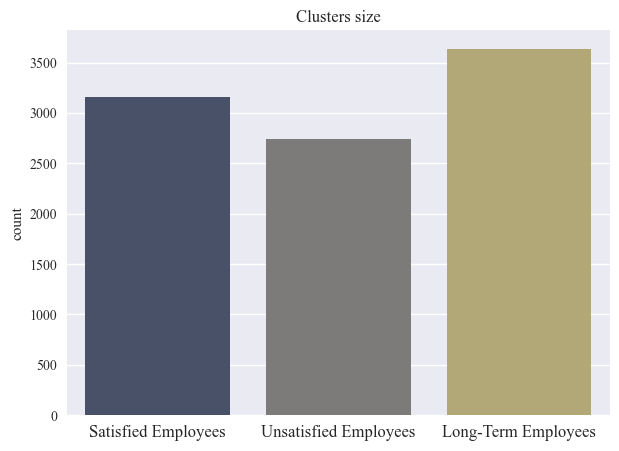

In the Satisfied Employees group there are 3156 employees ( 33.08 % of total employees)

In the Unsatisfied Employees group there are 2746 employees ( 28.78 % of total employees)

In the Long-Term Employees group there are 3638 employees ( 38.13 % of total employees)



In [36]:
# Checking clusters size
#plot
plt.figure(figsize = (7, 5))
sns.countplot(data=df_cluster, x = 'turnover_segmentation', palette='cividis')

#customize
plt.title('Clusters size')
plt.xticks(fontsize=12)
plt.xlabel('')

plt.show()

#number of employees in each cluster
for i in df_cluster['turnover_segmentation'].unique(): 
    x = df_cluster.loc[df_cluster['turnover_segmentation'].isin([i])]
    print(f'In the {Fore.GREEN}{i}{Style.RESET_ALL} group there are',
          len(x), 'employees (',
          round(len(x)/len(df)*100,2),'% of total employees)\n')

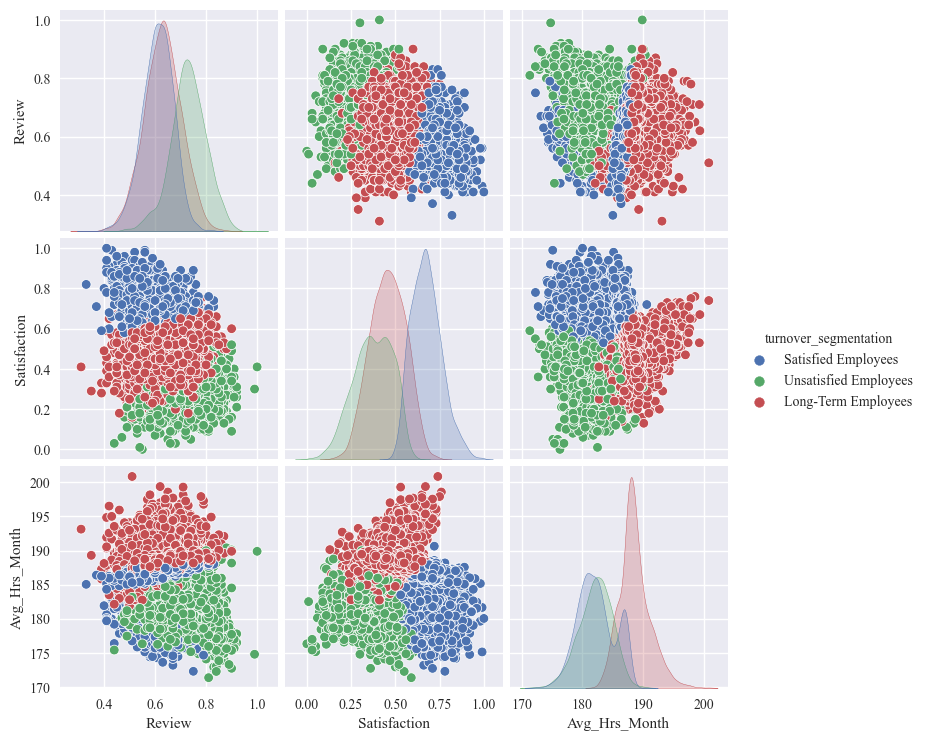

In [37]:
# Checking clusters distribution with boxplot
cols = turnover_features + ['turnover_segmentation']

#plot
sns.pairplot(data=df_cluster[cols], hue='turnover_segmentation')
plt.show()

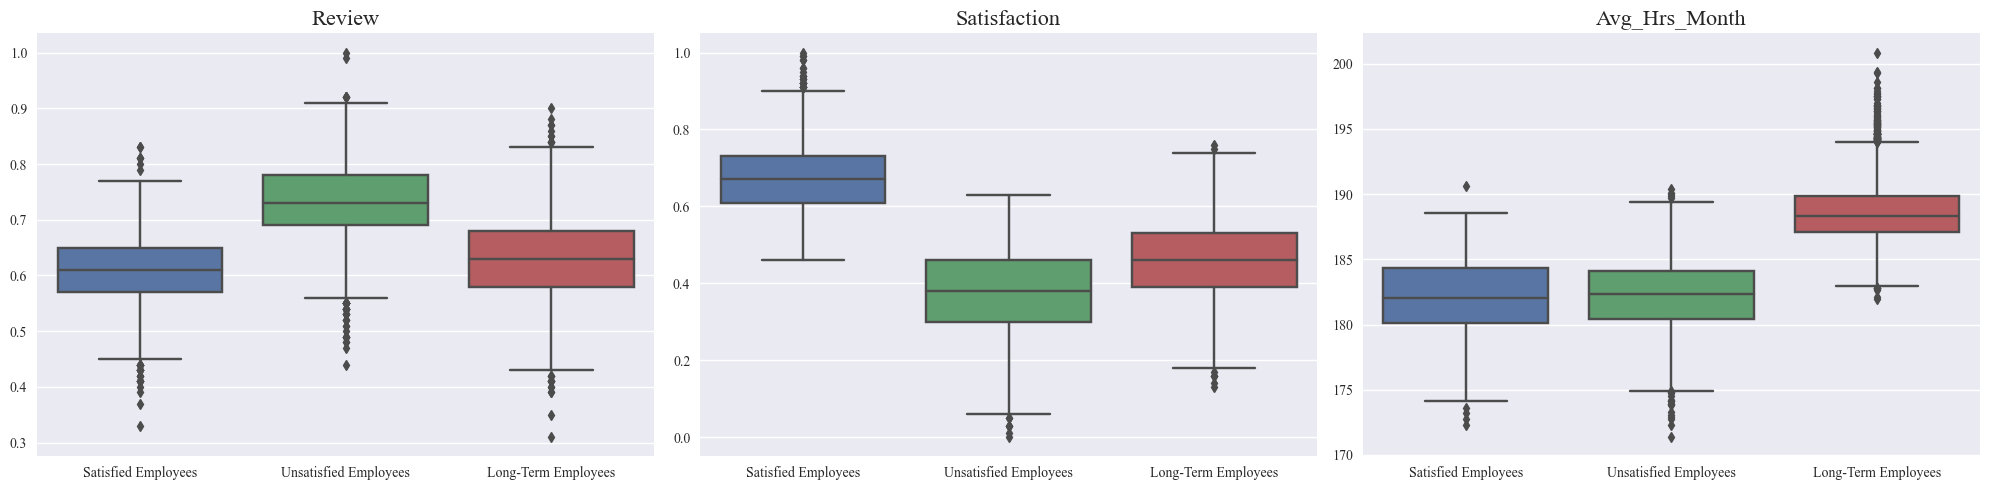

In [38]:
# Checking clusters distribution with boxplot
#plot
fig, ax = plt.subplots(nrows = 1, ncols = len(turnover_features), figsize = (20, 5))

#customize
for idx, c in enumerate(turnover_features):
    sns.boxplot(data = df_cluster, x = 'turnover_segmentation', y = c, ax = ax[idx])
    ax[idx].set_ylabel('')
    ax[idx].set_xlabel('')
    ax[idx].set_title(c, fontsize=16)
    
plt.tight_layout()

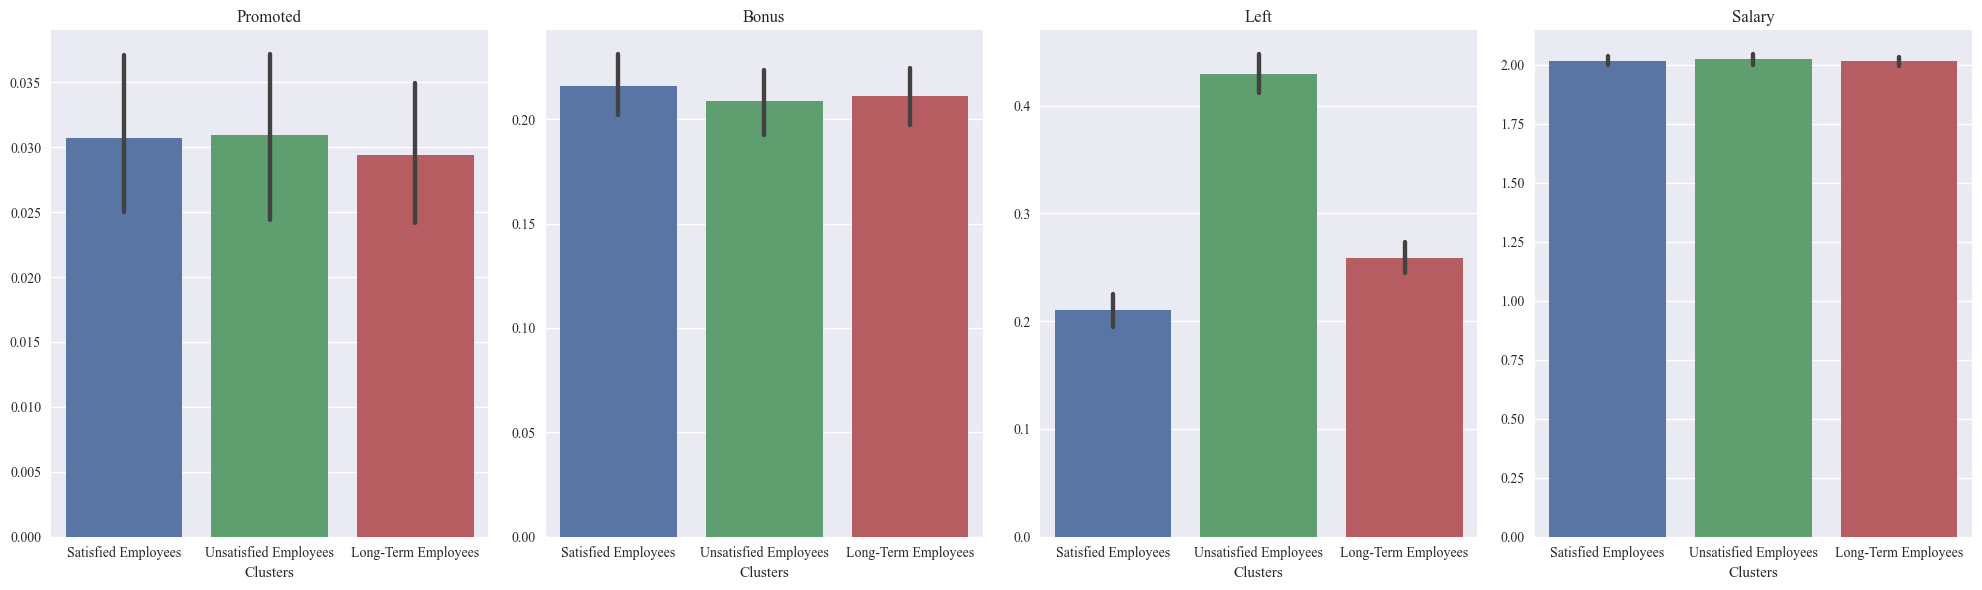

In [39]:
# Checking other features distribution per cluster with boxplot
#subset
binary_features = ['Promoted', 'Bonus','Left','Salary']

#plot
fig, ax = plt.subplots(nrows = 1, ncols = len(binary_features), figsize = (20, 6))

#customize
for idx, c in enumerate(binary_features):
    sns.barplot(data = df_cluster, x = 'turnover_segmentation', y = c, ax = ax[idx])
    ax[idx].set_ylabel('')
    ax[idx].set_xlabel('Clusters')
    ax[idx].set_title(c)
    
plt.tight_layout()

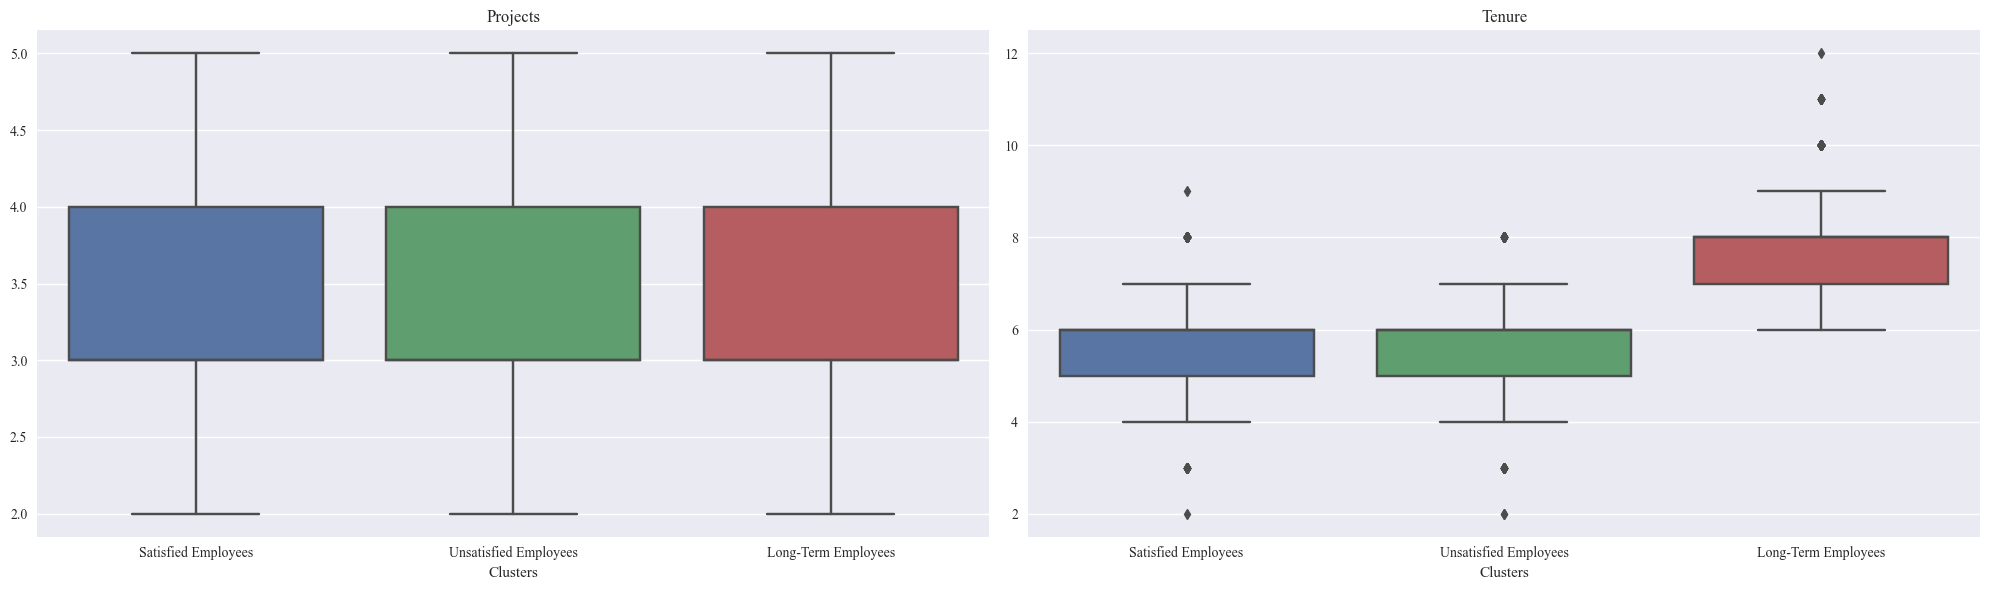

In [40]:
# Checking other features distribution per cluster with boxplot
#subset
other_features = ['Projects','Tenure']

#plot
fig, ax = plt.subplots(nrows = 1, ncols = len(other_features), figsize = (20, 6))

#customize
for idx, c in enumerate(other_features):
    sns.boxplot(data = df_cluster, x = 'turnover_segmentation', y = c, ax = ax[idx])
    ax[idx].set_ylabel('')
    ax[idx].set_xlabel('Clusters')
    ax[idx].set_title(c)
    plt.sca(ax[idx]) 
    
plt.tight_layout()

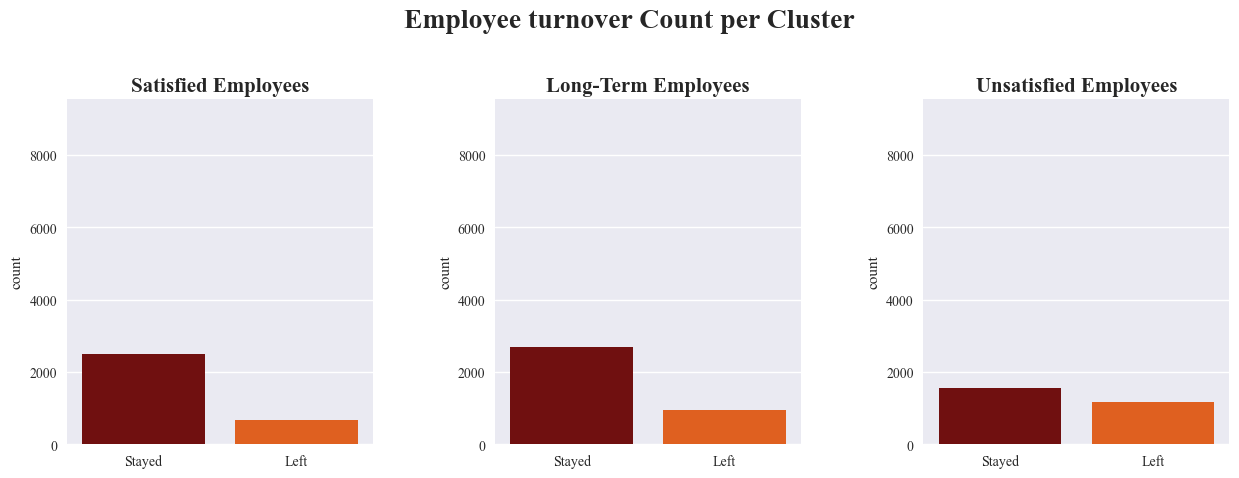

In the Satisfied group:
Nº of employee turnovers : 663 from 3156 employees( 21.01 % ) 

In the Long-Term group:
Nº of employee turnovers : 942 from 3638 employees( 25.89 %) 

In the Unsatisfied group:
Nº of employee turnovers : 1179 from 2746 employees( 42.94 %)


In [41]:
#subset 
tmp = df_cluster.loc[df_cluster['turnover_segmentation'].isin(['Satisfied Employees'])]
tmp1 = df_cluster.loc[df_cluster['turnover_segmentation'].isin(['Long-Term Employees'])]
tmp2 = df_cluster.loc[df_cluster['turnover_segmentation'].isin(['Unsatisfied Employees'])]

#plot
fig, ax = plt.subplots(1, 3, figsize = (15,5)) 

sns.countplot(data=tmp,x='Left', ax = ax[0], palette= 'gist_heat')
sns.countplot(data=tmp1,x='Left', ax = ax[1], palette= 'gist_heat')
sns.countplot(data=tmp2,x='Left', ax = ax[2], palette= 'gist_heat')

#customize
plt.rcParams['font.family'] = 'Times New Roman'
plt.suptitle('Employee turnover Count per Cluster',fontsize = 20, fontweight = 'bold')
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.8, wspace=0.4, hspace=None) 

for i in range(3): 
    ax[i].set_ylim(0,len(df))
    ax[i].set_xlabel('')
    plt.sca(ax[i])
    if i == 0: 
        ax[i].set_xticklabels({'Stayed':0,'Left':1})
        ax[i].set_title('Satisfied Employees' ,fontsize = 15, fontweight = 'bold')
    elif i == 1: 
        ax[i].set_xticklabels({'Stayed':0,'Left':1})
        ax[i].set_title('Long-Term Employees' ,fontsize = 15, fontweight = 'bold')
    else: 
        ax[i].set_xticklabels({'Stayed':0,'Left':1})
        ax[i].set_title('Unsatisfied Employees' ,fontsize = 15, fontweight = 'bold')
    
plt.show()

#Number of turnovers per cluster
satisfied = tmp.loc[tmp['Left'].isin([1])]
long_term = tmp1.loc[tmp1['Left'].isin([1])]
unsatisfied = tmp2.loc[tmp2['Left'].isin([1])]

print(f'In the {Fore.GREEN}Satisfied{Style.RESET_ALL} group:\nNº of employee turnovers :',len(satisfied),'from',len(tmp),
      'employees(',round(len(satisfied) * 100 / len(tmp),2),'% )', 
      f'\n\nIn the {Fore.GREEN}Long-Term{Style.RESET_ALL} group:\nNº of employee turnovers :',len(long_term),'from',len(tmp1),
      'employees(',round(len(long_term) * 100 / len(tmp1),2),'%)', 
      f'\n\nIn the {Fore.GREEN}Unsatisfied{Style.RESET_ALL} group:\nNº of employee turnovers :',len(unsatisfied),'from',len(tmp2),
      'employees(',round(len(unsatisfied)* 100 / len(tmp2),2),'%)')

### Profiling Clusters

> ##### Satisfied segment

In [42]:
#Analyzing the top 5 turnover count per departments
tmp = df_cluster.loc[df_cluster['turnover_segmentation'].isin(['Satisfied Employees'])& df_cluster['Left'].isin([1])]

tmp['Department'].value_counts().head()

Sales          125
Retail         119
Operations     102
Engineering     95
Marketing       63
Name: Department, dtype: int64

In [43]:
# What is the average Tenure from those who leave? 

print('Average years in the company before leaving:', round(tmp['Tenure'].mean(),2))

Average years in the company before leaving: 6.96


In [44]:
# What is the average Satisfaction from those who leave? 

print('Average satisfaction on working at the company before leaving:',
      round(tmp['Satisfaction'].mean(),2))

Average satisfaction on working at the company before leaving: 0.71


In [45]:
# What is the average Review from those who leave? 

print('Average performance evaluation score before leaving:',
      round(tmp['Review'].mean(),2))

Average performance evaluation score before leaving: 0.61


> ##### Long-Term segment

In [46]:
#Analyzing the top 5 turnover count per departments
tmp = df_cluster.loc[df_cluster['turnover_segmentation'].isin(['Long-Term Employees'])& df_cluster['Left'].isin([1])] 

tmp['Department'].value_counts().head()

Sales          183
Retail         156
Engineering    149
Operations     149
Support         79
Name: Department, dtype: int64

In [47]:
# What is the average tenure from those who leave? 

print('Average years in the company before leaving:', round(tmp['Tenure'].mean(),2))

Average years in the company before leaving: 7.78


In [48]:
# What is the average satisfaction from those who leave? 

print('Average satisfaction on working at the company before leaving:',
      round(tmp['Satisfaction'].mean(),2))

Average satisfaction on working at the company before leaving: 0.51


In [49]:
# What is the average Review from those who leave? 

print('Average performance evaluation score before leaving:', 
      round(tmp['Review'].mean(),2))

Average performance evaluation score before leaving: 0.65


In [50]:
tmp = df_cluster.loc[df_cluster['turnover_segmentation'].isin(['Long-Term Employees'])]

In [51]:
tmp['Avg_Hrs_Month'].mean()

188.607526113249

> ##### Unsatisfied segment

In [52]:
#Analyzing the top 5 turnover per departments 
tmp = df_cluster.loc[df_cluster['turnover_segmentation'].isin(['Unsatisfied Employees'])& df_cluster['Left'].isin([1])] 

tmp['Department'].value_counts().head()

Sales          229
Retail         196
Engineering    193
Operations     185
Marketing      110
Name: Department, dtype: int64

In [53]:
# What is the average tenure from those who leave? 

print('Average years in the company before leaving:', round(tmp['Tenure'].mean(),2))

Average years in the company before leaving: 5.41


In [54]:
# What is the average satisfaction from those who leave? 

print('Average satisfaction on working at the company before leaving:',
      round(tmp['Satisfaction'].mean(),2))

Average satisfaction on working at the company before leaving: 0.38


In [55]:
# What is the average Review from those who leave? 

print('Average performance evaluation score before leaving:', 
      round(tmp['Review'].mean(),2))

Average performance evaluation score before leaving: 0.77


### Clusters Analysis

With the clustering process, three groups were segmented from all the company's workforce, and since they were labeled regarding their characteristics the segment's names are: __Long-Term__ with 3838 employees (38.13% of the total), __Satisfied__ with 3156 (33.08%) and __Unsatisfied__ with 2746 (28.78%). 

The __Unsatisfied__ group, seems to be the most relevant cluster for this problem, because despite being the smallest of the three, it was by far the one who had the highest employee turnover count (1179) and turnover rate (43%). Its staff members average the best `Reviews` (0.73), meaning they provide the best performance/productivity in the company, yet they have been receiving very similar conditions and rewards as the other groups as observed in the `Salary`, `Bonus`, `Avg_Hrs_Month`, `Promoted` and `Bonus` averages. They're the ones who spend less time in the company averaging 5.72 years and the ones who show less satisfaction at work on surveys, averaging only 0.37 in 1. 

By profiling those who make part of the __Unsatisfied__ segment and left the organization (stats in Profiling section), it can be stated that they were the company's best performers (averaging a `Rating` of 0.77 in 1) but their work wasn't getting the recognition that it should, making them less attached to the organization (averaged 5.41 of `Tenure` which is the lowest value among people who left). This situation also elevated the tendency of __Unsatisfied__ employees to leave at a higher rate than in other segments (this can also be explained by their high value on the job market which probably means they have other career opportunities to consider).

The __Long-Term__ group is the largest cluster and it has the second highest employee turnover count (942) and turnover rate (26%). Its analysis reveals that this group is composed by those who have been the most loyal to the company, averaging the highest `Tenure` value (7.89) and the most work hours per month (188.6 hours). The almost perfect correlation between `Tenure` and `Avg_Hrs_Month` (0.98 coefficient) is fully displaced in this group, which is unattractive for those who want to stay. The employees from this segment averaged 0.63 in 1 (second highest) on `Review` and 0.45 in 1 on `Satisfaction`. They also tend to receive less promotions and bonuses despite being the ones who have more labor time which is reflecting on their well-being at work.

Looking at those employees who make part of the __Long-Term__ group and still left the company (stats in Profiling section), made possible to realize that these employees despite staying at the company for the longest periods (averaging 7.71 on `Tenure`), working more hours the other segments and presenting good performance (0.65 on `Review`) had practically the same salary as the other cluster's staff members. There's a negative correlation between `Avg_Hrs_Month` and `Satisfaction`, meaning the longer an employee stays at the company, the less happy he'll be there, so reducing working hours for those who work with the company over an extended period of time, would definitely benefit them in the long-term.

Observing the __Satisfied__ segment, shown that it's the second largest with the best employee turnover count (663) and turnover rate (21%). Their `Salary`, `Promoted` and `Bonus` averages seem to be equated to the other groups, but the main difference is that the staff members who make part of this segment seem to be ok with this, presenting a `Satisfaction` average of 0.67 in 1 (the highest). This might be explained by the fact that they also show the worst performance among clusters, averaging 0.61 on `Review`, meaning they might find the salary and promotion/bonus rate adequate. They have slightly higher `Tenure` and `Avg_Hrs_Month` averages than the __Unsatisfied__ but still lower than the __Long-Term__ employees. Despite being the cluster with the highest satisfaction, it still has a turnover rate higher than 20%.

If we look to the staff members from the __Satisfied__ group that left the company (stats in Profiling section), we found that they were extremely happy before leaving, averaging 0.71 on `Satisfaction` and showed a quite good performance with 0.61 on `Review` after spending an average 6.96 working at this company. The fact that the company isn't holding these type of employees, that despite being happy with their position/conditions, means that the competition/job market (companies from the same industry) is providing better opportunities.

### Finding Best Predictors 

Because the correlations coefficients weren't much revealing, in order to investigate which variables seem to be the best predictors of employee turnover, it'll be fitted a linear regression and a logistic regression models to the data. With this, it's possible to retrieve the __coef___ property, since its coefficients can provide the basis for a crude feature importance score.

> #### Linear Regression

In [56]:
# Data preparation
cols = ['Promoted','Review','Projects','Salary','Tenure','Satisfaction', 'Bonus', 'Avg_Hrs_Month']
X = df_cluster[cols]
y = df_cluster['Left']

In [57]:
# Creating object for linear regression
linear = linear_model.LinearRegression()

# Fitting the model for dataset
linear.fit(X, y)

LinearRegression()

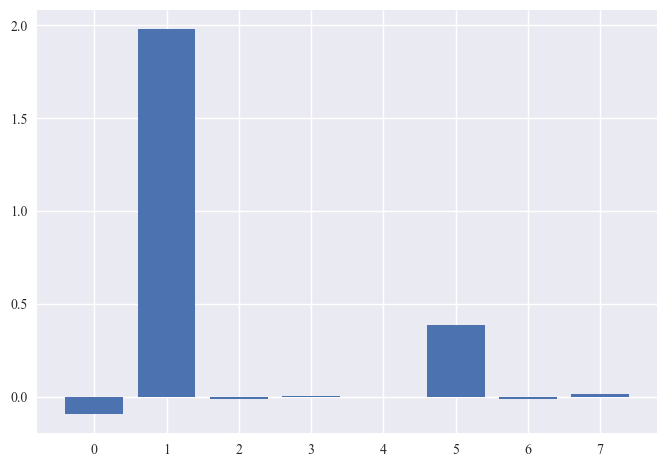

Feature 0 Promoted , Score: -0.09408
Feature 1 Review , Score: 1.97805
Feature 2 Projects , Score: -0.01137
Feature 3 Salary , Score: 0.00150
Feature 4 Tenure , Score: -0.00162
Feature 5 Satisfaction , Score: 0.38487
Feature 6 Bonus , Score: -0.01119
Feature 7 Avg_Hrs_Month , Score: 0.01165


In [58]:
# Getting importance
importance = linear.coef_
    
# plot
pyplot.bar([x for x in range(len(importance))], importance)

pyplot.show()

# Summarizing feature importance
for i,v in enumerate(importance):
    print(f'{Fore.GREEN}Feature %0d {cols[i]} {Style.RESET_ALL}, Score: %.5f' % (i,v))

> #### Logistic Regression

In [59]:
# Creating object for linear regression
logistic = LogisticRegression()

# Fitting the model for dataset
logistic.fit(X, y)

LogisticRegression()

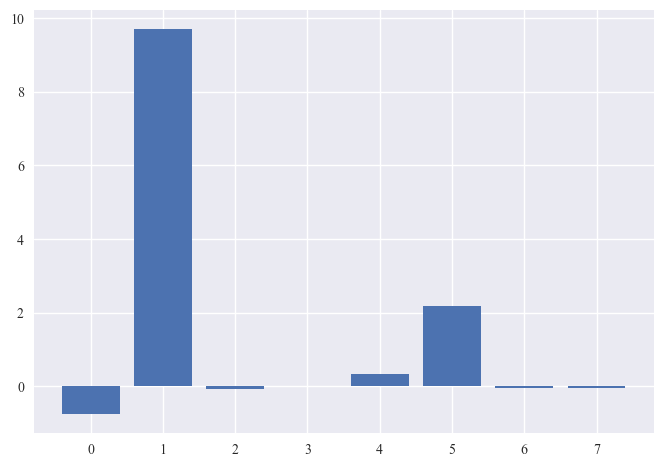

Feature 0 Promoted , Score: -0.75876
Feature 1 Review , Score: 9.70430
Feature 2 Projects , Score: -0.06663
Feature 3 Salary , Score: 0.01210
Feature 4 Tenure , Score: 0.31554
Feature 5 Satisfaction , Score: 2.16770
Feature 6 Bonus , Score: -0.03838
Feature 7 Avg_Hrs_Month , Score: -0.05542


In [60]:
# Getting importance
importance = logistic.coef_[0]

# plot
pyplot.bar([x for x in range(len(importance))], importance)

pyplot.show()

# Summarizing feature importance
for i,v in enumerate(importance):
    print(f'{Fore.GREEN}Feature %0d {cols[i]} {Style.RESET_ALL}, Score: %.5f' % (i,v))

> #### Best Predictors Conclusion 

The most important turnover predictors seem to be the variables `Review` and `Satisfaction`, since in both models they presented the highest coefficients amongst all features. Furthermore, this information reveals that high performance employees are more likely to leave the company. What can be done to foment talent retention?

### Challenge Questions

> #### Which department has the highest employee turnover? Which one has the lowest?

The department with the highest employee turnover in absolute values is the sales department with 537 from 1883 employees leaving the company (28.52%) and the one with the lowest is the Finance department with 26.87% (108 from 402 employees). In relative frequency terms and the highest employee turnover rate was registered in the It department with 30.9% (110 of 356 staff members left).Some notorious differences between these departments reside in the fact that employees that make part of the Finance section tend to receive more promotions and bonuses in average, comparing to the staff members in other departments. In contrast with this case, the It staff that are the ones who are less likely to get a promotion and also have little chances on receiving a bonus even though they're the ones who average the highest number of years at the company and hours of work.

> #### Investigate which variables seem to be better predictors of employee departure.

After using a linear regression and a logistic regression models in the data with the intent of extract the variables coefficients, since they provide the basis for a crude feature importance score. It was possible to observe that the variable with most influence on predicting who will leave the company is `Review`. This means that high performance employees are finding better conditions somewhere and that this company needs to develop career progression strategies and other talent retention systems so it doesn't keep losing its best workforce. Also, the second best predictor is `Satisfaction`, which can imply that even though the employees might like the work environment, they'll still leave the company regardless.

> #### What recommendations would you make regarding ways to reduce employee turnover?

Organizations generally aim for 10% for an employee turnover rate, but the majority fall into the range between 12% and 20%. The company under this study presented an abnormal turnover rate, rounding 30% of its total workforce. Some specific industries reveal higher rates, but in this case, this information is not revealed. 

The main cause of this problem seems to be the lack of a meritocracy system, in a sense that they're losing their most valuable employees because they're not rewarding them for their work. The company's anual promotions rate is at 3% and bonus rate at 20%, their employees with better performance seem to be unsatisfied with their professional progress/position at the company, causing them to depart. 

I suggest the company to take different strategies for the different clusters of employees. To the __Unsatisfied__ staff members, which presented the highest performance metrics, the company should take talent retention actions like promoting career progression opportunities, sharing the decision-making with adequate personnel, implementing a reward productivity system with bonuses and/or gifts and raising the salaries of those who deserve it.

For the __Long-Term__ segment, since they´re the most ternured ones, they should provide the most experienced employees with leadership opportunities, increased benefits like reduced labor time (the opposite of what's happening), higher salaries and/or bonuses, etc... and an anual salary raise between 10% and 20% to incentivate the employers to stay, because usually that's the average raise an employee receives for leaving according to Forbes. 

[Forbes article](https://www.forbes.com/sites/cameronkeng/2014/06/22/employees-that-stay-in-companies-longer-than-2-years-get-paid-50-less/)

For the __Satisfied__ segment, the company should invest on understanding in more detail why they are leaving (21.01% turnover rate) by doing interviews, because according to the satisfaction surveys, they're happy there. Asking questions to those who leave, will expose their point of view and create understanding on the details of what they're doing wrong or not doing. I believe the interview before the employee leave the company should be applied to all segments nevertheless. 

The company has to invest to resolve this situation, because having almost 30% of general employee turnover rate causes instability in the company and might influentiate or encourage others to do so.

